In [1]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods

from utils import set_plotting_style, numba_histogram, numba_histogram2d, make_profile

In [2]:
set_plotting_style()

In [538]:
%%time
# fdata = awkward.load("data/table_1.awkd")
# fdata = uproot.open("data/output_1.root")["Events"]
fdata = uproot.open("data/data_2018C_1fb.root")["Events"]
fmc = uproot.open("data/baby_HToZZTo2Mu2X_ctau50mm_skim2mu.root")["Events"]
fs = dict(data=fdata,mc=fmc)
cache = uproot.ArrayCache("16GB")
# readkw = dict(cache=cache,entrystop=20000000)
readkw = dict(cache=cache,entrystop=10000000)

CPU times: user 322 ms, sys: 14 ms, total: 336 ms
Wall time: 1.11 s


In [539]:
%%time
# beamspot shift
bsx = dict(data=np.nanmean(fs["data"].array("PV_x",cache=cache,entrystop=100000).mean()), mc=0)
bsy = dict(data=np.nanmean(fs["data"].array("PV_y",cache=cache,entrystop=100000).mean()), mc=0)

CPU times: user 194 ms, sys: 8 ms, total: 202 ms
Wall time: 343 ms


In [540]:
cache._cache.currsize/1e9

0.007822664

In [541]:
# cache._cache.keys()

{'label': 'Muon qoverpError', 'logx': False, 'logy': False}
{'label': 'Muon qoverp', 'logx': False, 'logy': False}
{'label': 'Muon qoverp', 'logx': False, 'logy': False}
CPU times: user 2.41 s, sys: 819 ms, total: 3.23 s
Wall time: 3.23 s


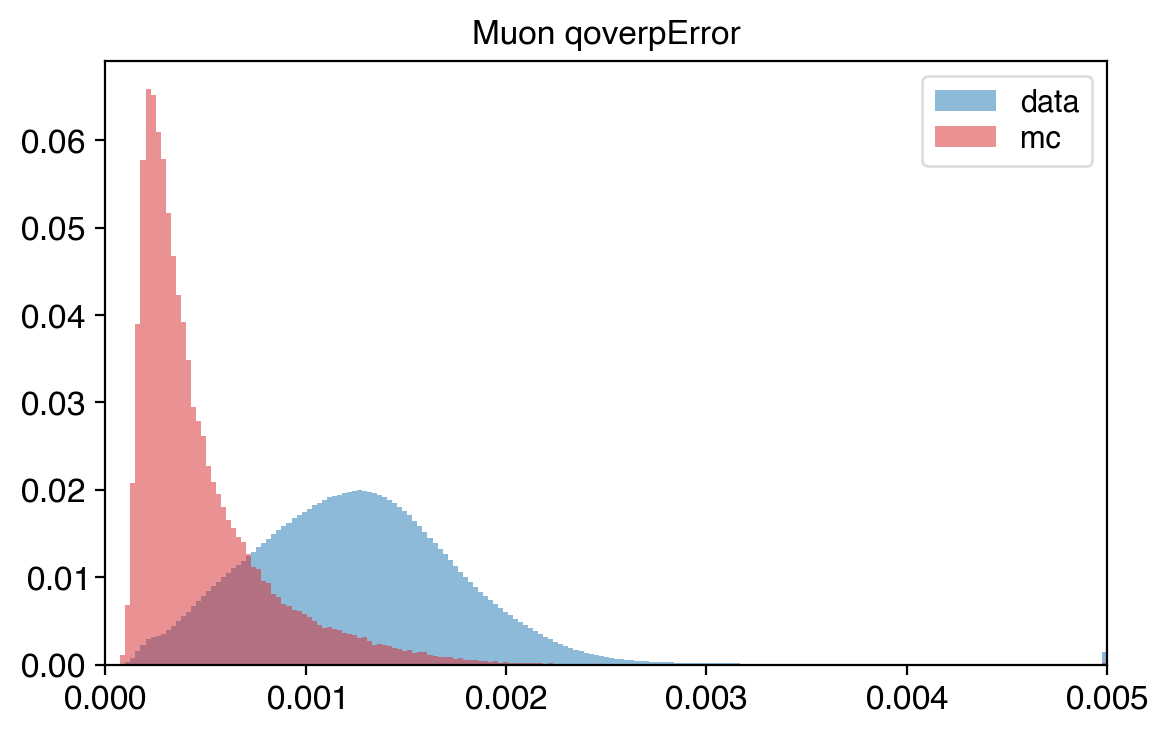

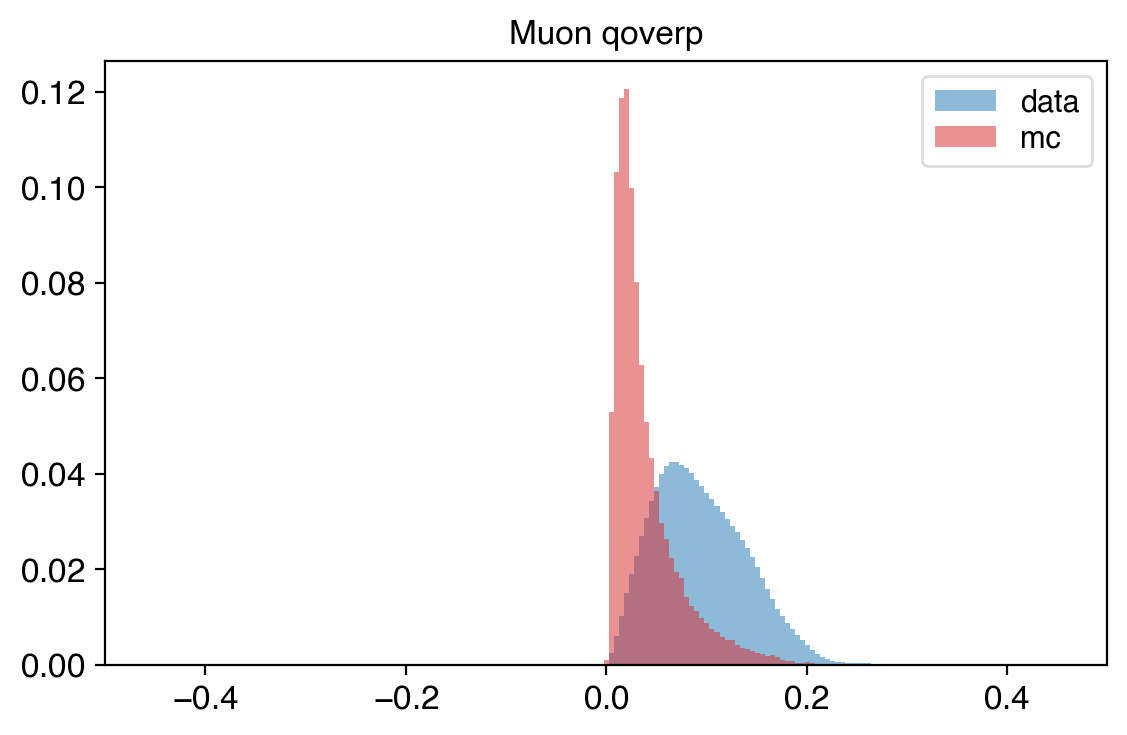

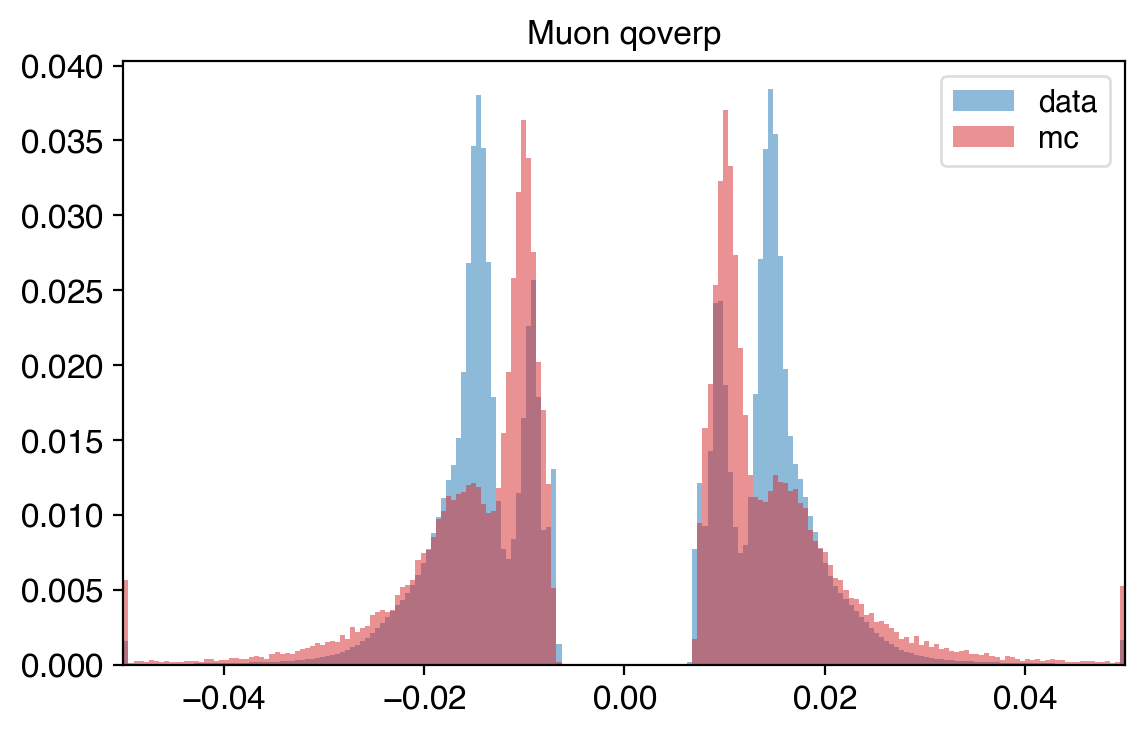

In [298]:
%%time

def singleplot(varname,do_abs=False):
    if do_abs:
        return lambda which:np.abs(fs[which][varname].array(**readkw))[:,[0,1]].flatten()
    else:
        return lambda which:(fs[which][varname].array(**readkw))[:,[0,1]].flatten()

def ratioplot(varname1,varname2,do_abs=False):
    if do_abs:
        return lambda which:np.abs(fs[which][varname1].array(**readkw)/fs[which][varname2].array(**readkw))[:,[0,1]].flatten()
    else:
        return lambda which:(fs[which][varname1].array(**readkw)/fs[which][varname2].array(**readkw))[:,[0,1]].flatten()

def rhoplot():
    return lambda which: np.hypot(fs[which].array("DV_x",**readkw)[:,0]-bsx[which],fs[which].array("DV_y",**readkw)[:,0]-bsy[which])

def costhetaplot():
    return lambda which: uproot_methods.TVector2Array.from_polar(
                fs[which].array("Muon_pt",**readkw)[:,[0,1]],fs[which].array("Muon_phi",**readkw)[:,[0,1]]
            ).cosdelta(
                uproot_methods.TVector2Array.from_cartesian(
                    fs[which].array("DV_x",**readkw)[:,[0]]-bsx[which],fs[which].array("DV_y",**readkw)[:,[0]]-bsy[which]
                )
    ).flatten()
        
def dvrplot():
    return lambda which: ((fs[which]["DV_xError"].array(**readkw)**2.
         +fs[which]["DV_yError"].array(**readkw)**2.
         +fs[which]["DV_zError"].array(**readkw)**2.
         )**0.5/
        (fs[which]["DV_x"].array(**readkw)**2.
         +fs[which]["DV_y"].array(**readkw)**2.
         +fs[which]["DV_z"].array(**readkw)**2.
         )**0.5)[:,0]

plots = [
    [np.logspace(-4,1.5,100),rhoplot(),dict(label="DV rho",logx=True,logy=True)],
    [np.linspace(0,0.05,100),dvrplot(),dict(label="DV rError/r",logx=False,logy=False)],
    [np.linspace(-1,1,30),costhetaplot(),dict(label="cosTheta",logx=False,logy=False)],
    
    [np.linspace(0,100,200),singleplot("Muon_pt"),dict(label="Muon pT",logx=False,logy=False)],
    [np.linspace(-2.5,2.5,200),singleplot("Muon_eta"),dict(label="Muon eta",logx=False,logy=False)],
    [np.linspace(-3.2,3.2,200),singleplot("Muon_phi"),dict(label="Muon phi",logx=False,logy=False)],
    
    [np.logspace(-4.,1,100),singleplot("Muon_dxy",do_abs=True),dict(label="Muon dxy",logx=True,logy=False)],
    [np.logspace(-3.5,-1.5,100),singleplot("Muon_dxyError"),dict(label="Muon dxyError",logx=True,logy=False)],
    [np.logspace(-4,1,100),ratioplot("Muon_dxyError","Muon_dxy",do_abs=True),dict(label="Muon dxyError/dxy",logx=True,logy=False)],
    [np.linspace(-15,15,200),singleplot("Muon_dz"),dict(label="Muon dz",logx=False,logy=False)],
    [np.linspace(0,0.05,200),singleplot("Muon_dzError"),dict(label="Muon dzError",logx=False,logy=False)],
    [np.linspace(0,0.03,200),ratioplot("Muon_dzError","Muon_dz",do_abs=True),dict(label="Muon dzError/dz",logx=False,logy=False)],
    [np.linspace(0,0.05,200),ratioplot("Muon_trk_qoverpError","Muon_trk_qoverp",do_abs=True),dict(label="Muon qoverpError/qoverp",logx=False,logy=False)],
    
    [np.linspace(0,5,200),ratioplot("Muon_chi2","Muon_ndof"),dict(label="Muon chi2/ndof",logx=False,logy=False)],
    [np.linspace(0,5,50),singleplot("Muon_trackIso"),dict(label="Muon trackIso",logx=False,logy=True)],
    
    [np.linspace(0,100,101),singleplot("Muon_nValidMuonHits"),dict(label="Muon nValidMuonHits",logx=False,logy=False)],
    [np.linspace(0,10,11),singleplot("Muon_nValidPixelHits"),dict(label="Muon nValidPixelHits",logx=False,logy=False)],
    [np.linspace(0,30,31),singleplot("Muon_nValidStripHits"),dict(label="Muon nValidStripHits",logx=False,logy=False)],
    [np.linspace(0,10,11),singleplot("Muon_nMatchedStations"),dict(label="Muon nMatchedStations",logx=False,logy=False)],
    [np.linspace(0,20,21),singleplot("Muon_nTrackerLayersWithMeasurement"),dict(label="Muon nTrackerLayersWithMeasurement",logx=False,logy=False)],
    
]

# dce = {}
# dvar = {}
for bins,varf,extra in plots:
    fig,ax = plt.subplots()
    print(extra)
    for which in ["data","mc"]:
        var = varf(which)
        counts,edges = numba_histogram(var,bins=bins,overflow=True)
        ax.bar(edges[:-1],counts/counts.sum(),align="edge",width=edges[1:]-edges[:-1],alpha=0.5,color="C3" if which=="mc" else "C0",label=which)
#         dce[which] = (counts,edges)
#         dvar[which] = var
    # if np.nanargmax(dce["mc"][0])<np.nanargmax(dce["data"][0]):
    #     flip = -1 # or 1
    # else:
    #     flip = 1 # or 1
    # sb = dce["mc"][0][::flip].cumsum()/(dce["data"][0][::flip].cumsum()**0.5)
    # bestidx = np.nanargmax(sb[::flip])
    # bestx = dce["data"][1][::flip][bestidx]
    # ax.vlines([bestx],0,1.0,transform=ax.get_xaxis_transform(), colors='k')

    # ax.set_yscale("log")
    if extra.get("logx"):
        ax.set_xscale("log")
    if extra.get("logy"):
        ax.set_yscale("log")
    ax.set_title(extra.get("label"))
    ax.legend()

In [542]:
vrc = {}

In [543]:
%%time
which = "data"
# which = "mc"
costheta = uproot_methods.TVector2Array.from_polar(
                fs[which].array("Muon_pt",**readkw)[:,[0,1]],fs[which].array("Muon_phi",**readkw)[:,[0,1]]
            ).cosdelta(
                uproot_methods.TVector2Array.from_cartesian(
                    fs[which].array("DV_x",**readkw)[:,[0]]-bsx[which],fs[which].array("DV_y",**readkw)[:,[0]]-bsy[which]
#                     fs[which].array("DV_x",**readkw)[:,[0]],fs[which].array("DV_y",**readkw)[:,[0]]
                )
            ).flatten()
rho = np.repeat(np.hypot(fs[which].array("DV_x",**readkw)[:,0]-bsx[which],fs[which].array("DV_y",**readkw)[:,0]-bsy[which]),2)

dvx = fs[which].array("DV_x",**readkw)[:,0].flatten()
dvy = fs[which].array("DV_y",**readkw)[:,0].flatten()
dvz = fs[which].array("DV_z",**readkw)[:,0].flatten()
vx  = np.repeat(dvx,2)
vy  = np.repeat(dvy,2)
vz  = np.repeat(dvz,2)

vrc[which] = (rho,costheta)

print(costheta.shape)
print(rho.shape)

(20000000,)
(20000000,)
CPU times: user 18.1 s, sys: 18.1 s, total: 36.2 s
Wall time: 1min 15s


In [544]:
# plt.hist(costheta.reshape(-1,2)[:,1],bins=np.linspace(-1,1,20));

CPU times: user 1.65 s, sys: 8.8 s, total: 10.4 s
Wall time: 10.5 s


Text(0.5, 0, 'DV rho')

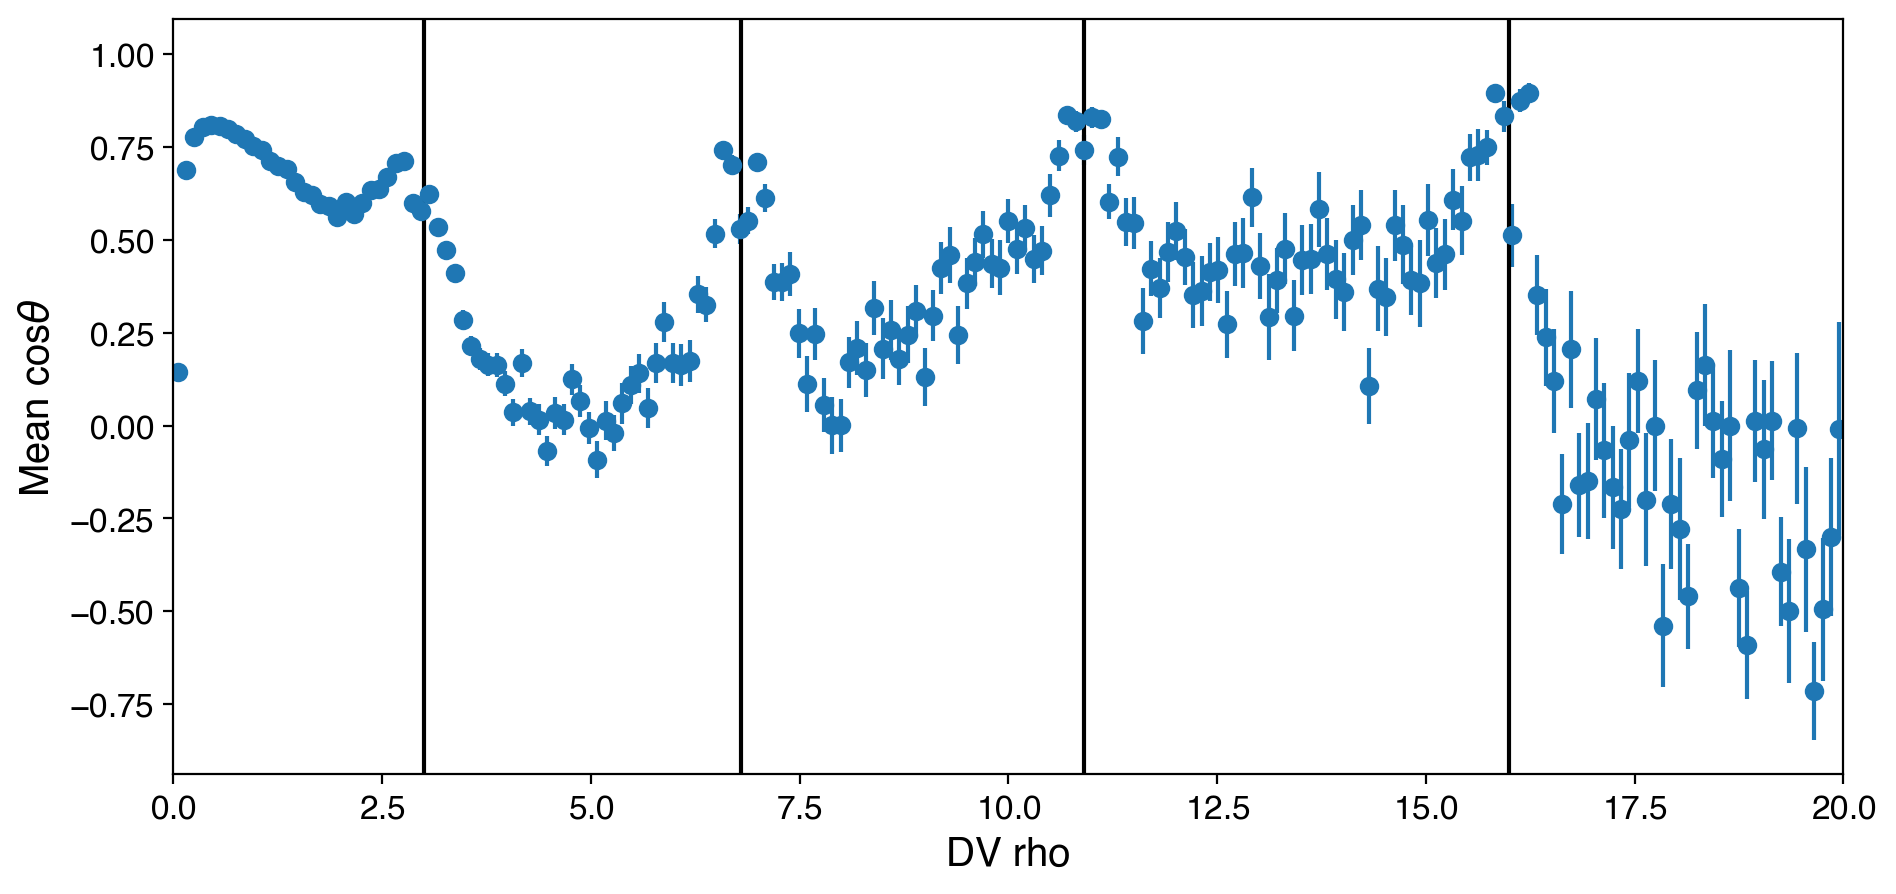

In [545]:
%%time
from scipy.stats import binned_statistic
# edges = np.logspace(0.,1.5,200)
edges = np.linspace(0.0,20.,200)
yvals = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'mean', bins=edges).statistic
yerr = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'std', bins=edges).statistic/(binned_statistic(rho, costheta, 'count', bins=edges).statistic**0.5)
fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o')
ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# ax.set_xscale("log")
ax.set_ylabel(r"Mean cos$\theta$")
ax.set_xlabel("DV rho")

KeyError: 'mc'

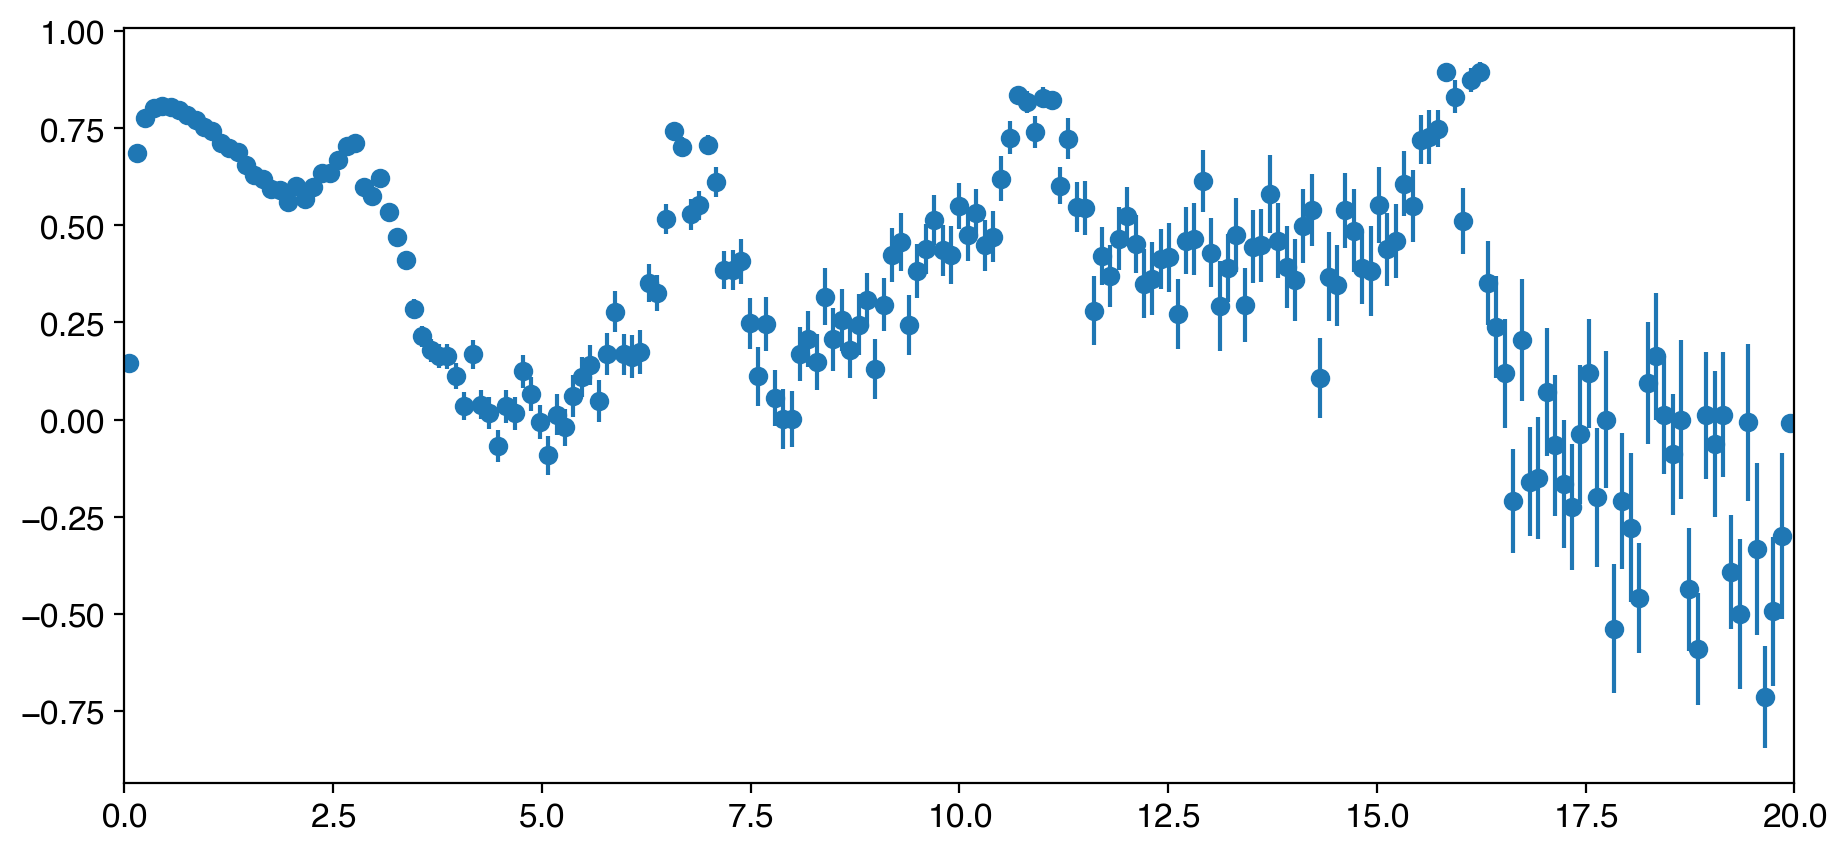

In [546]:
%%time
from scipy.stats import binned_statistic
edges = np.linspace(0.0,20.,200)
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2

fig,ax = plt.subplots(figsize=(10,5))

rho,costheta = vrc["data"]
yvals, yerr = make_profile(np.clip(rho,edges[0],edges[-1]), costheta, edges=edges)
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o',color="C0",label="data")

rho,costheta = vrc["mc"]
yvals, yerr = make_profile(np.clip(rho,edges[0],edges[-1]), costheta, edges=edges)
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o',color="C3",label="mc")

ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
ax.set_ylabel(r"Mean cos$\theta$")
ax.set_xlabel("DV rho")
ax.legend()

CPU times: user 150 ms, sys: 25 ms, total: 175 ms
Wall time: 184 ms


Text(0.5, 0, 'DV x (cm)')

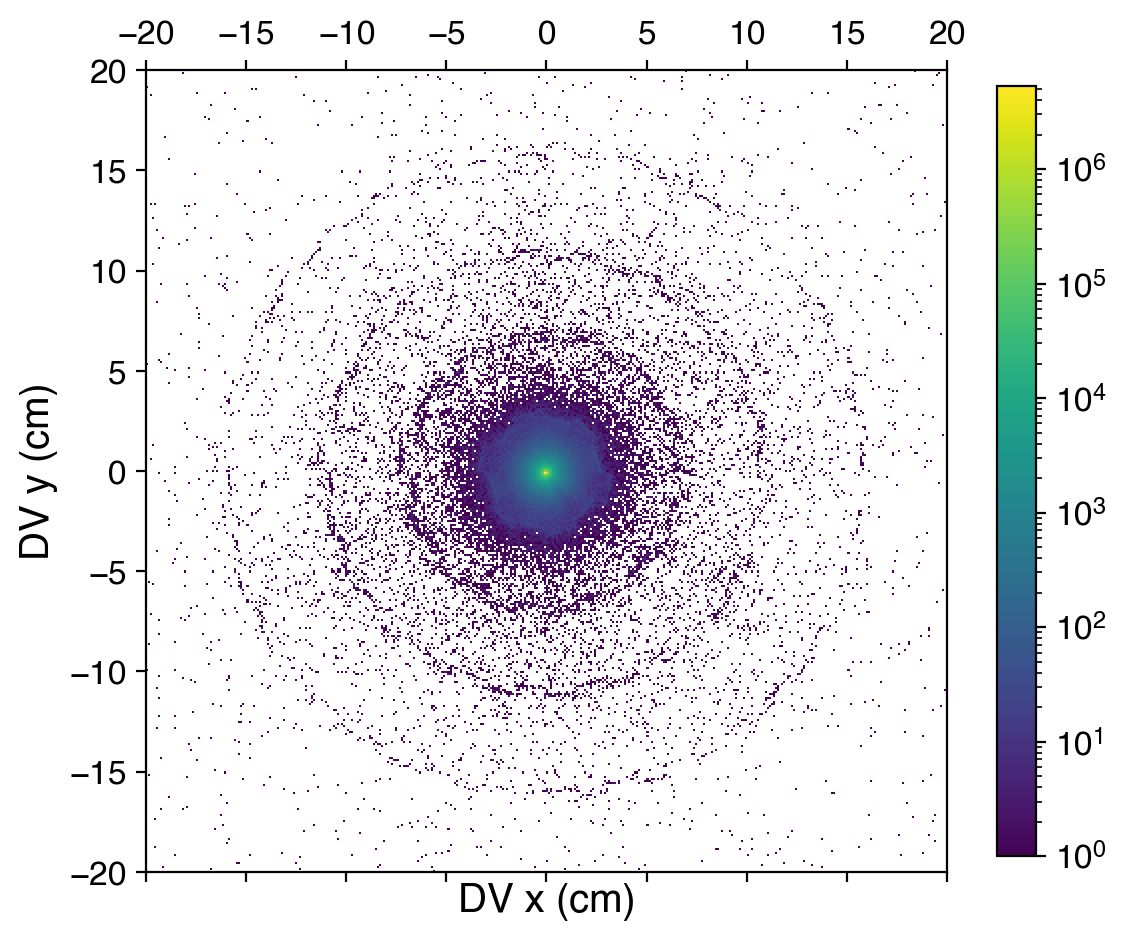

In [547]:
%%time
which = "data"
edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
counts, _, _ = numba_histogram2d(dvx,dvy,edgesx,edgesy)
fig,ax = plt.subplots(figsize=(6,6))
H = ax.matshow(
    counts,norm=LogNorm(),extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.85)
ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")

ax.set_ylabel("displaced vertex y (cm)")
ax.set_xlabel("displaced vertex x (cm)")
fig.set_tight_layout(True)
os.system("mkdir -p plots_for_claudio")
fig.savefig("plots_for_claudio/effrho_fiducial.png")
fig.savefig("plots_for_claudio/effrho_fiducial.pdf")

In [105]:
%%time
from scipy.stats import binned_statistic_2d
# edges = np.linspace(0.0,20.,200)
edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
yvals = binned_statistic_2d(vx,vy, costheta, 'mean', bins=[edgesx,edgesy]).statistic
# sel = np.abs(vz)>15
# yvals = binned_statistic_2d(vx[sel],vy[sel], costheta[sel], 'mean', bins=[edgesx,edgesy]).statistic

CPU times: user 2.57 s, sys: 15.1 s, total: 17.7 s
Wall time: 17.9 s


CPU times: user 41 ms, sys: 3 ms, total: 44 ms
Wall time: 40 ms


Text(0.5, 0, 'DV x (cm)')

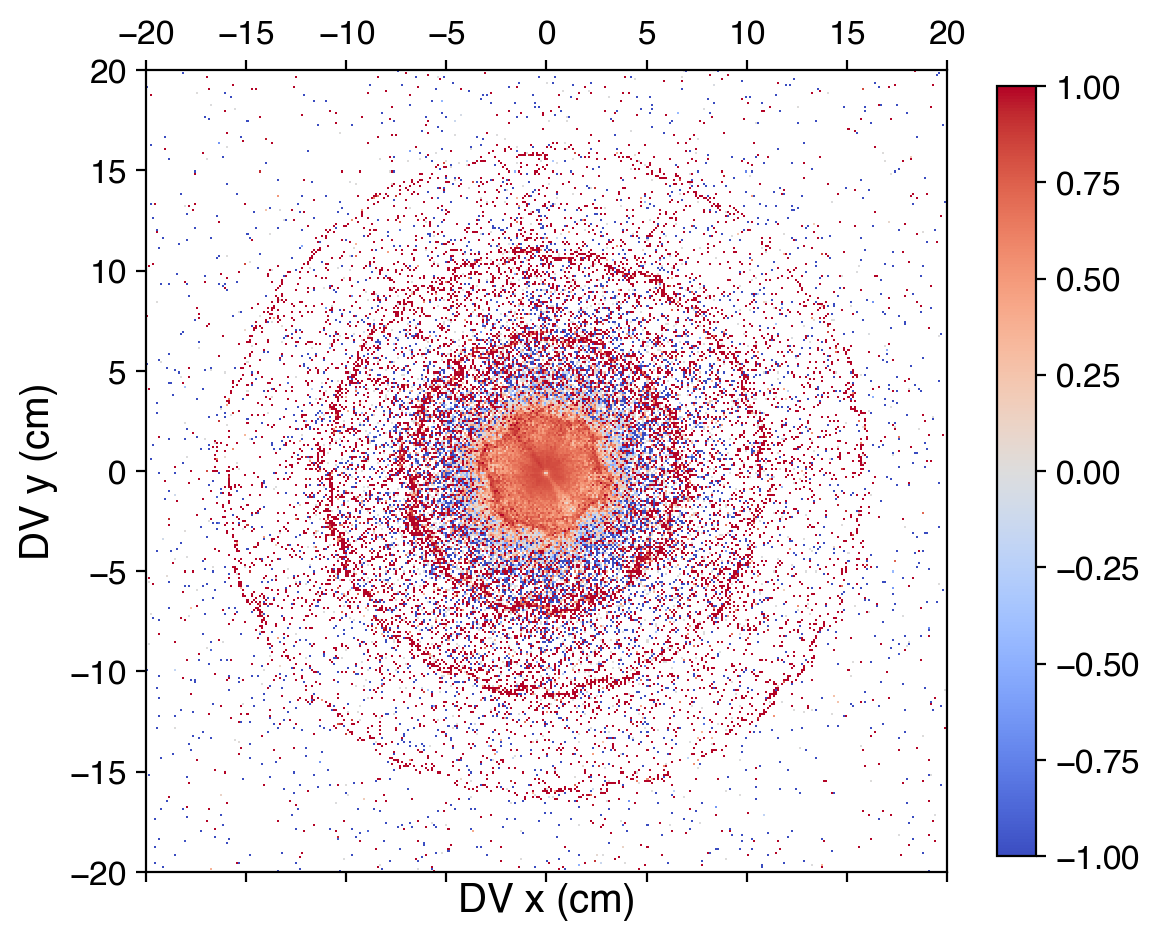

In [106]:
%%time
fig,ax = plt.subplots(figsize=(6,6))
H = ax.matshow(
    yvals,
#     norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
    cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.85)
ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")

In [107]:
print(bsx,vx.mean())
print(bsy,vy.mean())

{'data': 0.09734954658133431, 'mc': 0} 0.09464447
{'data': -0.05870136259301689, 'mc': 0} -0.06155367


In [108]:

%%time
from scipy.stats import binned_statistic_2d
# edges = np.linspace(0.0,20.,200)
edgesx,edgesy = np.linspace(-50,50,200),np.linspace(0,20,200)
yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'mean', bins=[edgesx,edgesy]).statistic
# yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'count', bins=[edgesx,edgesy]).statistic
# sel = np.abs(vz)>15
# yvals = binned_statistic_2d(vx[sel],vy[sel], costheta[sel], 'mean', bins=[edgesx,edgesy]).statistic

CPU times: user 2.93 s, sys: 13.5 s, total: 16.4 s
Wall time: 16.6 s


CPU times: user 33 ms, sys: 5 ms, total: 38 ms
Wall time: 33.4 ms


Text(0.5, 0, 'DV z (cm)')

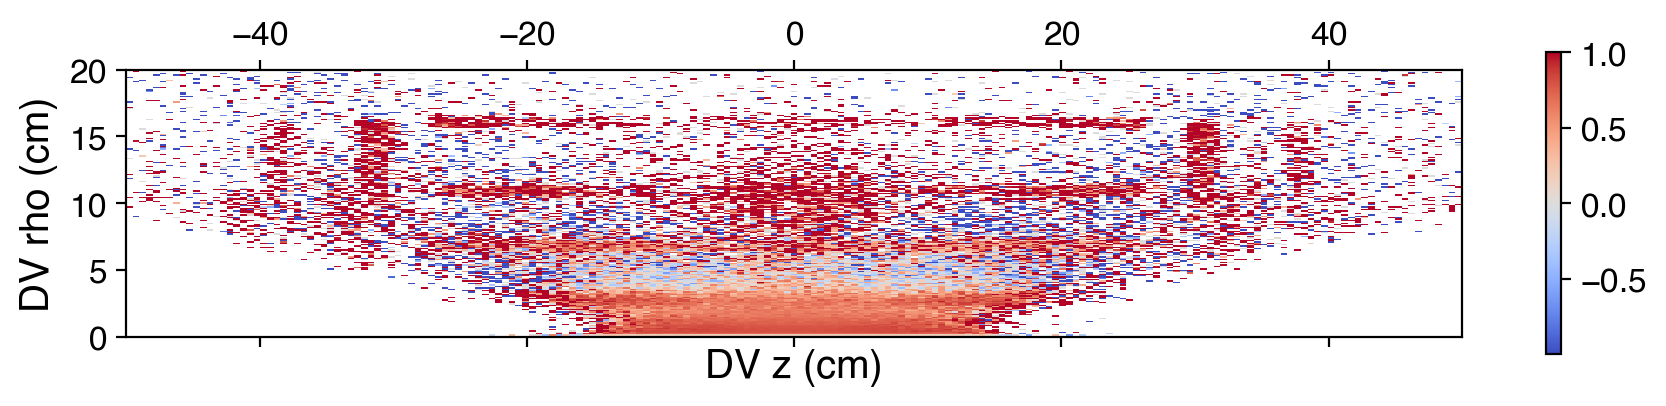

In [109]:

%%time
fig,ax = plt.subplots(figsize=(10,10))
H = ax.matshow(
    yvals.T[::-1,::1],
#     yvals[::1,::-1].T,
#     norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
    cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.20)
ax.set_ylabel("DV rho (cm)")
ax.set_xlabel("DV z (cm)")

In [110]:
%%time
from scipy.stats import binned_statistic_2d
edgesx,edgesy = np.linspace(-50,50,200),np.linspace(0,20,200)
yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'count', bins=[edgesx,edgesy]).statistic

CPU times: user 2.77 s, sys: 13.8 s, total: 16.6 s
Wall time: 16.8 s


CPU times: user 35 ms, sys: 6 ms, total: 41 ms
Wall time: 31.7 ms


Text(0.5, 0, 'DV z (cm)')

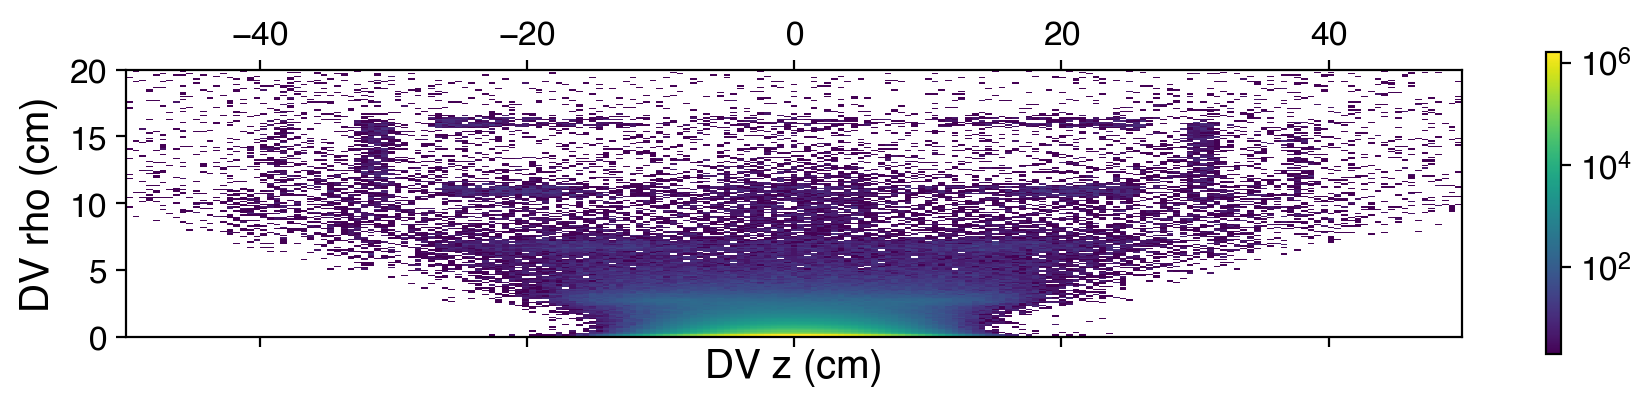

In [111]:

%%time
fig,ax = plt.subplots(figsize=(10,10))
H = ax.matshow(
    yvals.T[::-1,::1],
#     yvals[::1,::-1].T,
    norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
#     cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.20)
ax.set_ylabel("DV rho (cm)")
ax.set_xlabel("DV z (cm)")

In [85]:
# which = "data"
# # which = "mc"
# extra = dict(cache=cache,entrystop=2000000)
# dvx = fs[which].array("DV_x",**extra)
# dvy = fs[which].array("DV_y",**extra)
# dvz = fs[which].array("DV_z",**extra)

# pvx = fs[which].array("PV_x",**extra)
# pvy = fs[which].array("PV_y",**extra)
# pvz = fs[which].array("PV_z",**extra)

# # pvx = fs[which].array("PVM_x",**extra)
# # pvy = fs[which].array("PVM_y",**extra)
# # pvz = fs[which].array("PVM_z",**extra)

# mudz = fs[which].array("Muon_dz",**extra)

In [112]:
# pvx = fs[which].array("PVM_x",**extra)
# dvx.counts.min()
# pd.Series(pvx.counts).value_counts()

In [113]:
# plt.hist2d(
#     fs[which].array("PVM_x",**extra).mean(),
#     fs[which].array("PV_x",**extra).mean(),
# #     fs[which].array("DV_x",**extra).mean(),
#     bins=[
#         np.linspace(0.094,0.100,100),
#         np.linspace(0.094,0.100,100),
# #         np.linspace(-2,2,100),
#     ],
#     norm=LogNorm()
# );

In [114]:
%%time
# edges = np.linspace(-10,10,100)

# yvals,yerr =  make_profile(dvx[:,0],pvx[:,0],edges=edges)
# # yvals,yerr =  make_profile(dvy[:,0],pvy[:,0],edges=edges)

# fig,ax = plt.subplots(figsize=(10,5))
# centers = 0.5*(edges[1:]+edges[:-1])
# xerr = (edges[1:]-edges[:-1])/2
# ax.errorbar(centers,yvals,xerr=xerr,yerr=yerr,fmt='o',ms=5.0)
# # ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# # ax.set_xscale("log")
# # ax.set_ylabel(r"Mean cos$\theta$")
# # ax.set_xlabel("DV rho")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.2 µs


In [ ]:
# prof

In [ ]:
# # mudz
# # pvz
# plt.hist2d(
#     mudz[:,0],
# #     pvz[:,0],
#     dvz[:,0],
# #     mudz[:,0],
# #     mudz[:,1],
# #     fs[which].array("PVM_x",**extra).mean(),
# #     fs[which].array("PV_x",**extra).mean(),
# #     fs[which].array("DV_x",**extra).mean(),
#     bins=[
#         np.linspace(-10,10,100),
#         np.linspace(-10,10,100),
# #         np.linspace(0.094,0.100,100),
# #         np.linspace(0.094,0.100,100),
# #         np.linspace(-2,2,100),
#     ],
#     norm=LogNorm()
# );

In [ ]:
# mult = 1e4
# # now all in microns
# print(pvx.content.mean()*mult,pvx.content.std()*mult)
# print(pvy.content.mean()*mult,pvy.content.std()*mult)
# print(pvz.content.mean()*mult,pvz.content.std()*mult)

In [301]:
eta = fs["data"]["Muon_eta"].array(**readkw)

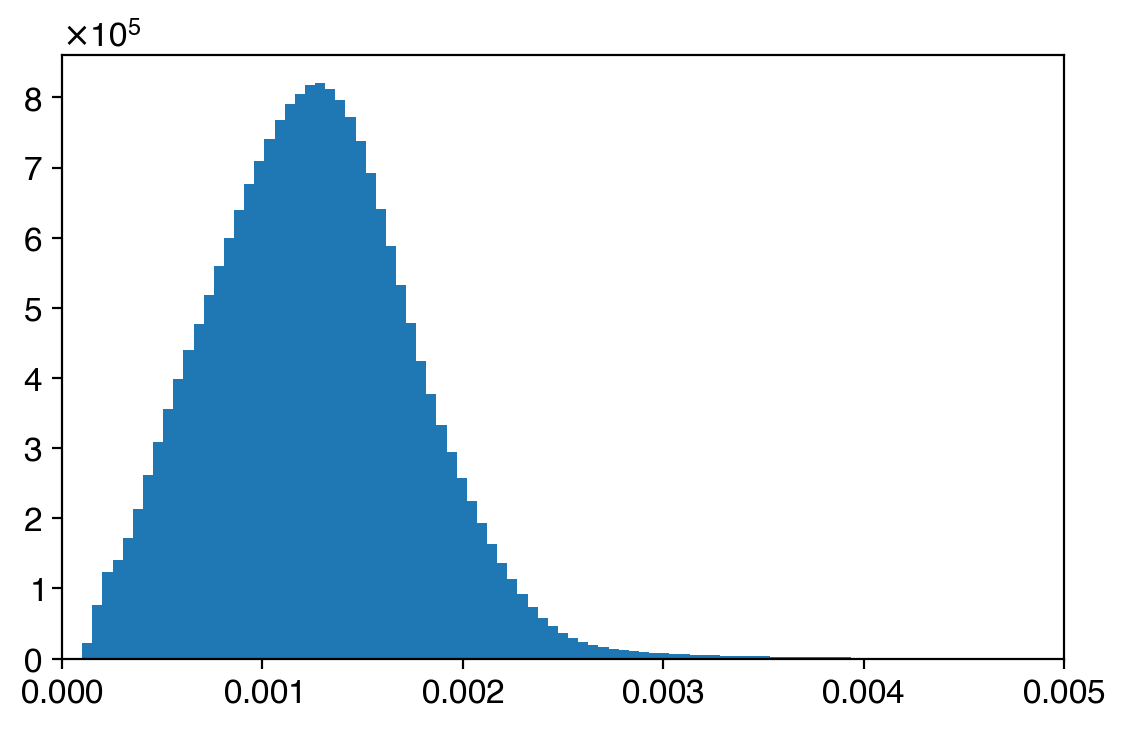

In [307]:
qperr = fs["data"]["Muon_trk_qoverpError"].array(**readkw)
_ = plt.hist(qperr.flatten(),bins=np.linspace(0,0.005,100));

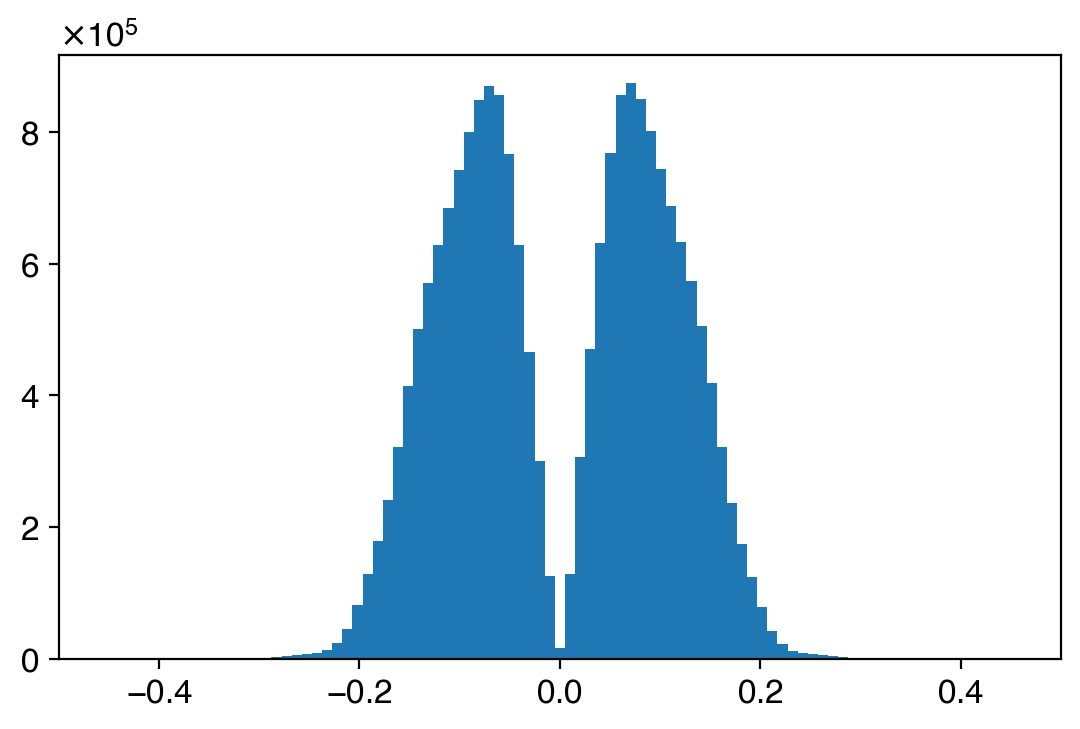

In [311]:
qp = fs["data"]["Muon_trk_qoverp"].array(**readkw)
_ = plt.hist(qp.flatten(),bins=np.linspace(-0.5,0.5,100));

In [322]:
sel = np.abs(eta)>1.0

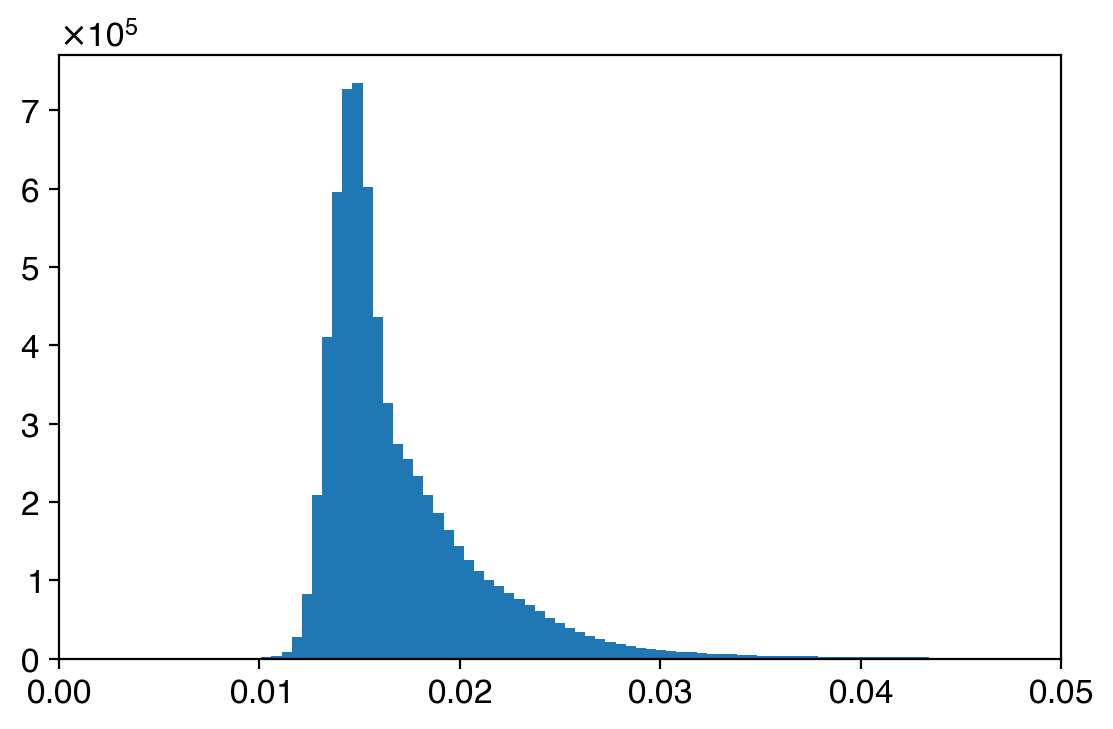

In [323]:
ratio = qperr/qp
_ = plt.hist(ratio[sel].flatten(),bins=np.linspace(0,0.05,100));

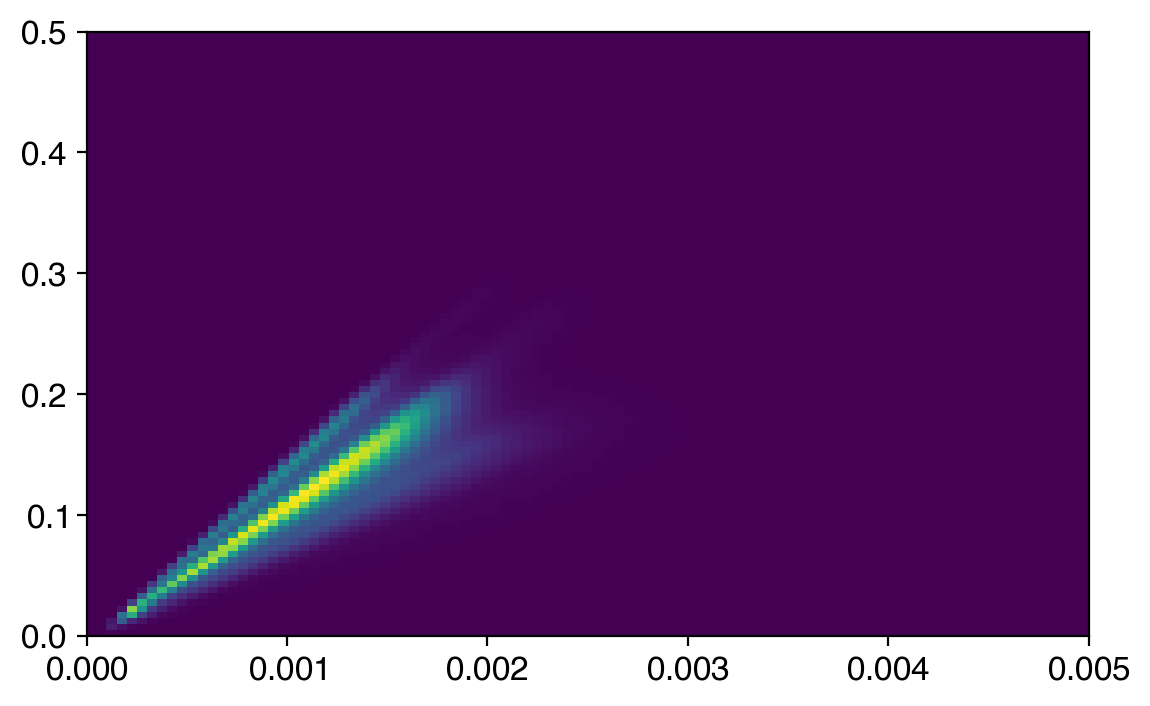

In [320]:
plt.hist2d(
    qperr[sel].flatten(),
    np.abs(qp[sel]).flatten(),
    bins=[
        np.linspace(0,0.005,100),
        np.linspace(0,0.5,100),
    ],
#     norm=LogNorm()
);

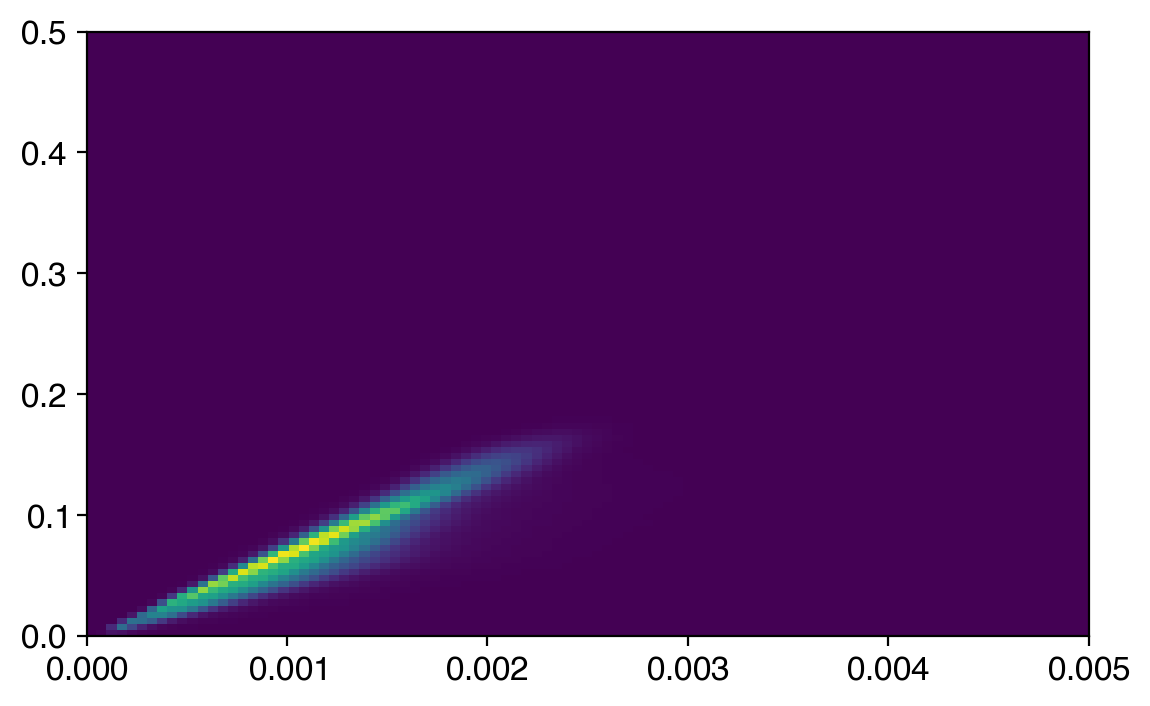

In [321]:
sel = np.abs(eta)>1.0
plt.hist2d(
    qperr[sel].flatten(),
    np.abs(qp[sel]).flatten(),
    bins=[
        np.linspace(0,0.005,100),
        np.linspace(0,0.5,100),
    ],
#     norm=LogNorm()
);

In [324]:
%%time

CPU times: user 85 ms, sys: 431 ms, total: 516 ms
Wall time: 522 ms


In [412]:
%%time
fsctaus = {}
bsxctau = {}
bsyctau = {}
for ctau in [50,20,10,5]:
    t = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau{}mm_skim2mu.root".format(ctau))["Events"]
    fsctaus[ctau] = t
    bsxctau[ctau] = t.array("PVM_x",**readkw).content.mean()
    bsyctau[ctau] = t.array("PVM_y",**readkw).content.mean()

CPU times: user 598 ms, sys: 27 ms, total: 625 ms
Wall time: 1.29 s


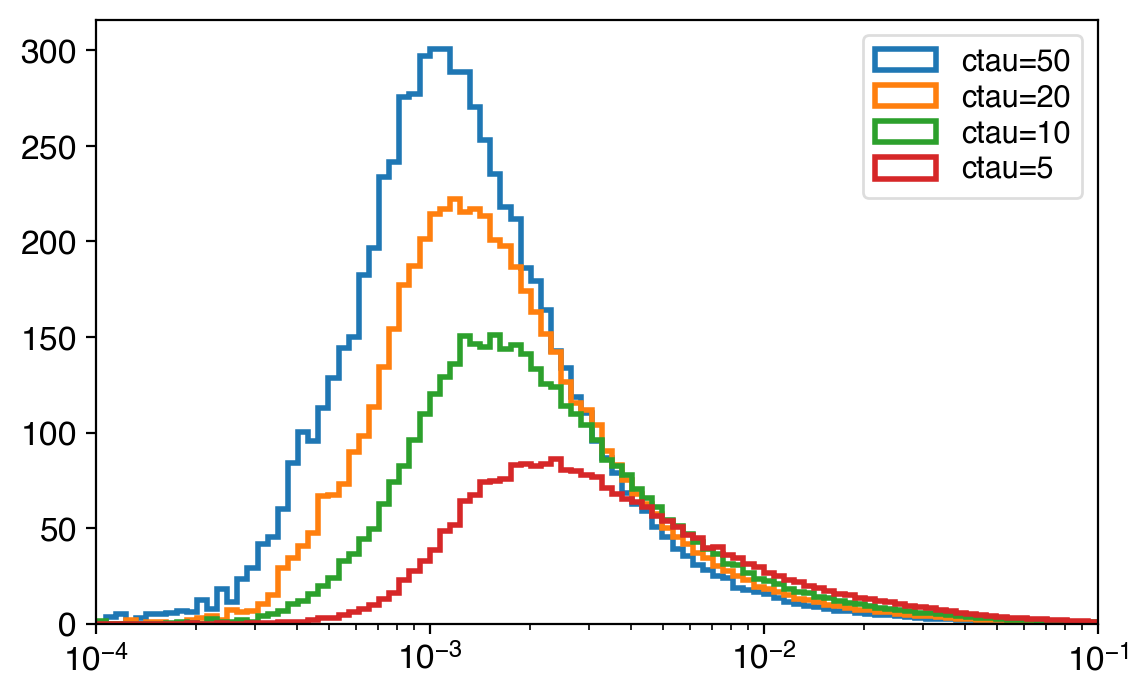

In [413]:
fig,ax = plt.subplots()
for ctau in [50,20,10,5]:
    t = fsctaus[ctau]
    r = np.abs(t["Muon_dxyError"].array(**readkw)/t["Muon_dxy"].array(**readkw))
#     r = np.abs(t["Muon_dxy"].array(**readkw))
#     r = np.abs(t["Muon_dxyError"].array(**readkw))

    ax.hist(r.flatten(),bins=np.logspace(-4,-1,100),histtype="step",lw=2,label="ctau={}".format(ctau),density=True);
#     ax.hist(r.flatten(),bins=np.linspace(0,20.,100),histtype="step",lw=2,label="ctau={}".format(ctau),density=True);
#     ax.hist(r.flatten(),bins=np.linspace(0,0.05,100),histtype="step",lw=1.5,label="ctau={}".format(ctau),density=True);
ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend()

{'label': 'DV rho', 'logx': True, 'logy': False}
{'label': 'DV rError/r', 'logx': False, 'logy': False}
{'label': 'cosTheta', 'logx': False, 'logy': False}
{'label': 'Muon pT', 'logx': False, 'logy': False}
{'label': 'Muon eta', 'logx': False, 'logy': False}
{'label': 'Muon phi', 'logx': False, 'logy': False}
{'label': 'Muon dxy', 'logx': True, 'logy': False}
{'label': 'Muon dxyError', 'logx': True, 'logy': False}
{'label': 'Muon dxyError/dxy', 'logx': True, 'logy': False}
{'label': 'Muon dz', 'logx': False, 'logy': False}
{'label': 'Muon dzError', 'logx': False, 'logy': False}
{'label': 'Muon dzError/dz', 'logx': False, 'logy': False}
{'label': 'Muon qoverpError/qoverp', 'logx': False, 'logy': False}
{'label': 'Muon chi2/ndof', 'logx': False, 'logy': False}
{'label': 'Muon trackIso', 'logx': False, 'logy': True}
{'label': 'Muon nValidMuonHits', 'logx': False, 'logy': False}
{'label': 'Muon nValidPixelHits', 'logx': False, 'logy': False}
{'label': 'Muon nValidStripHits', 'logx': False,

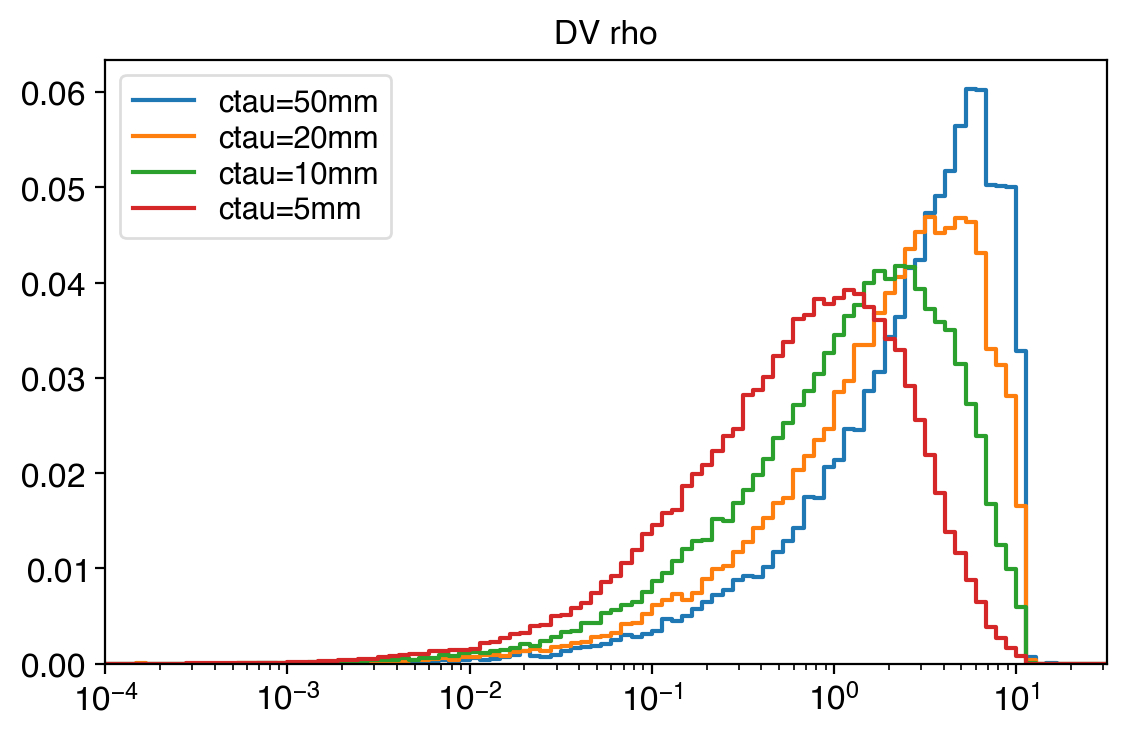

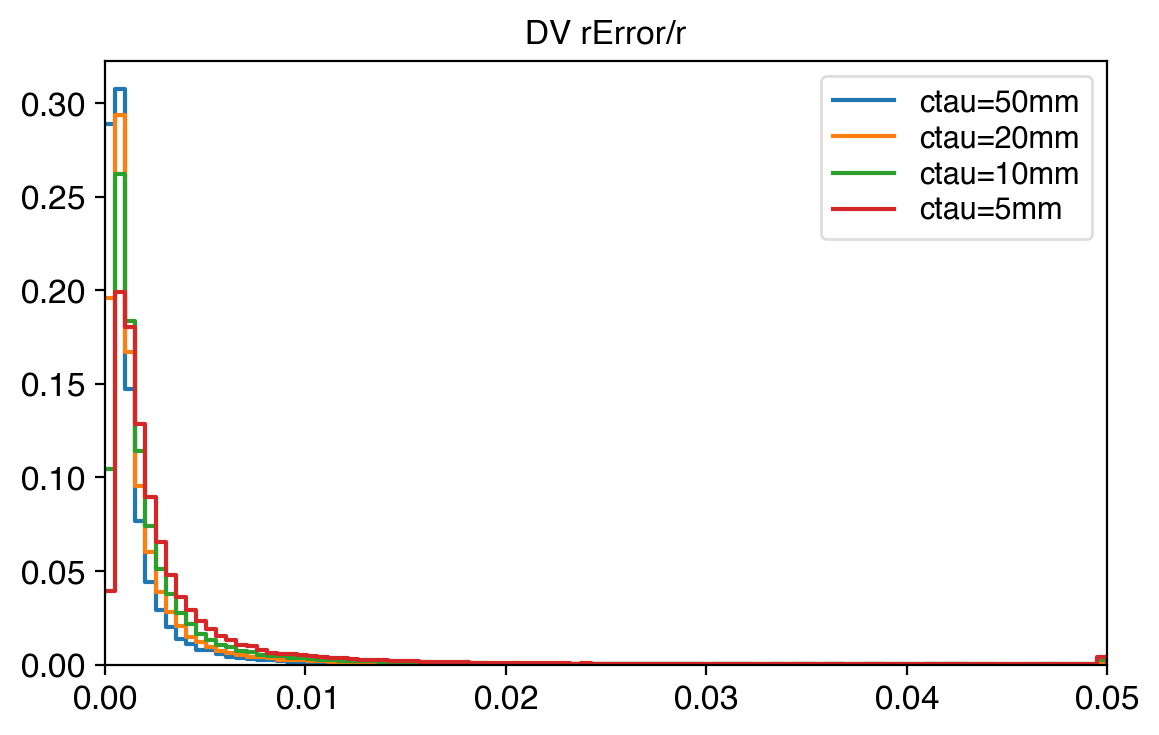

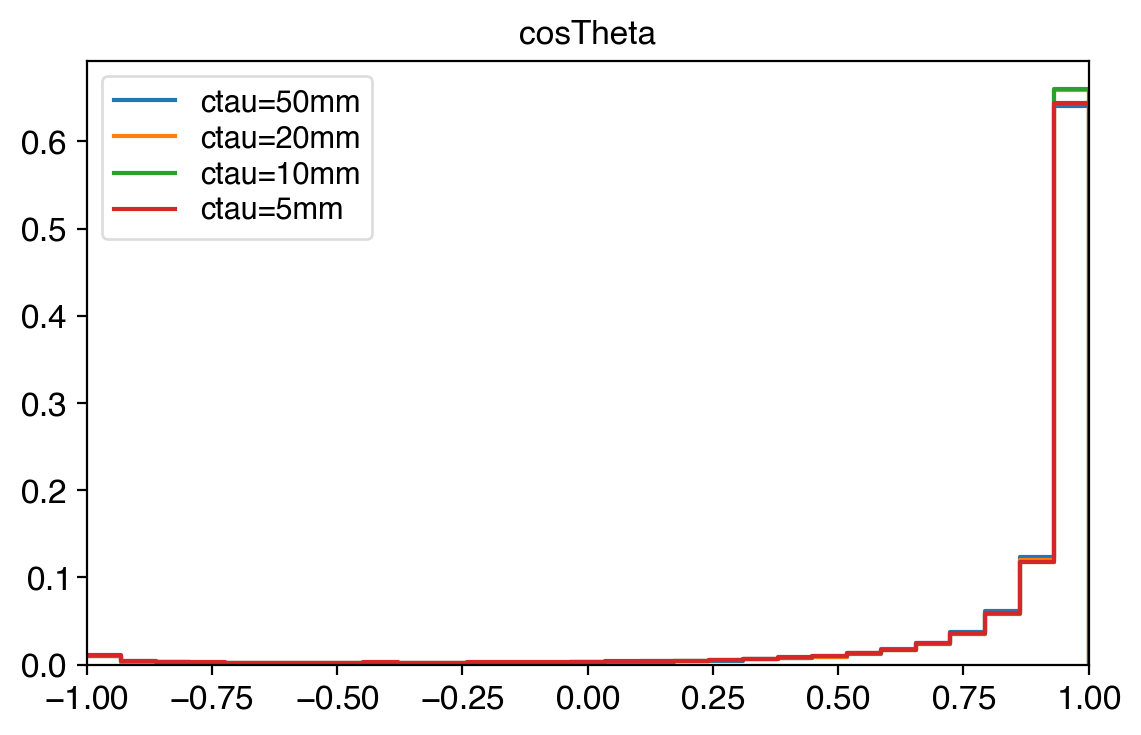

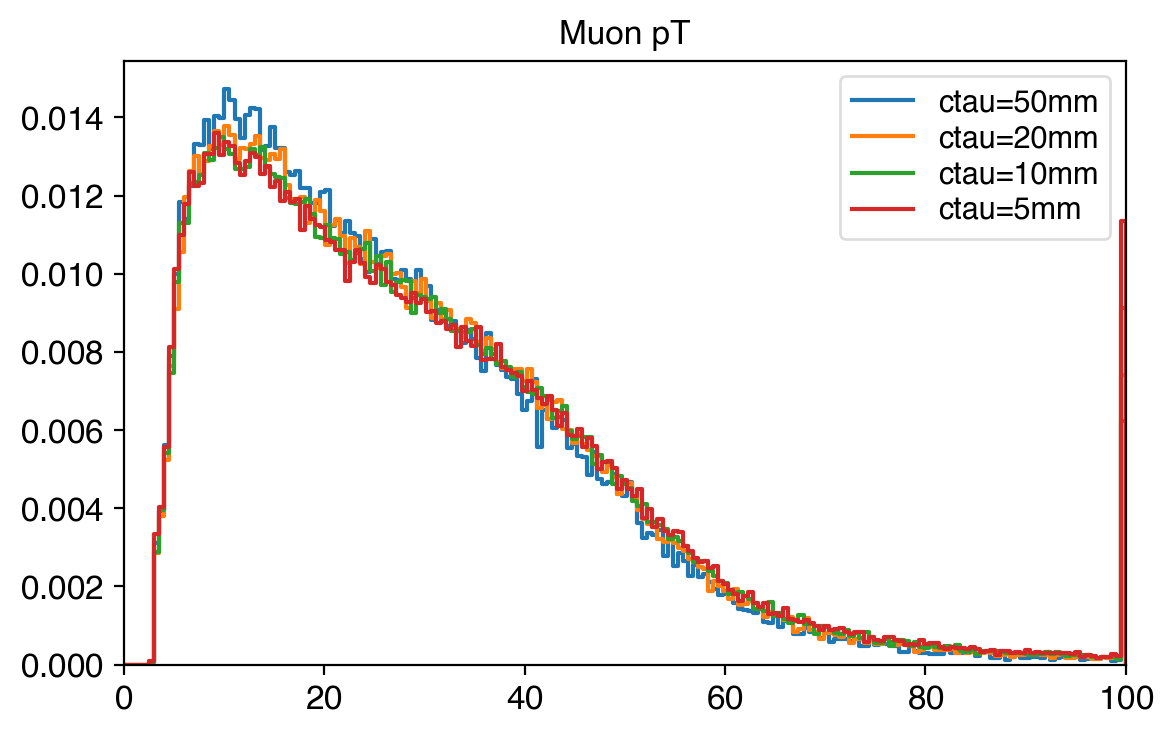

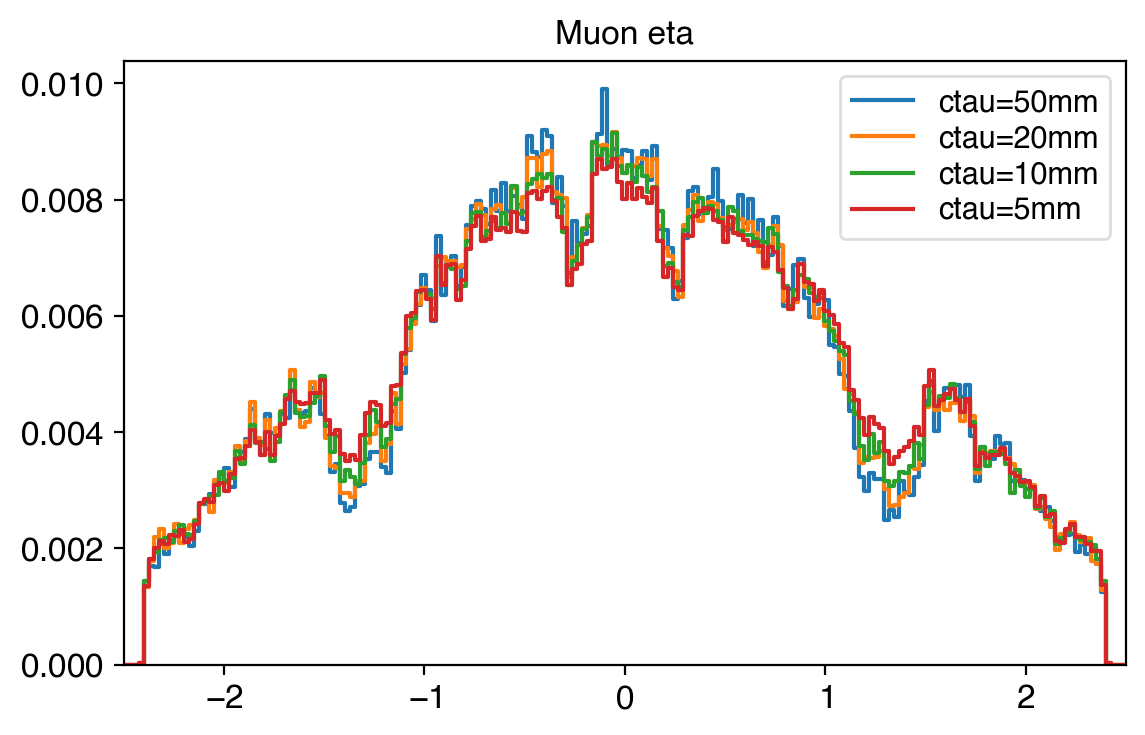

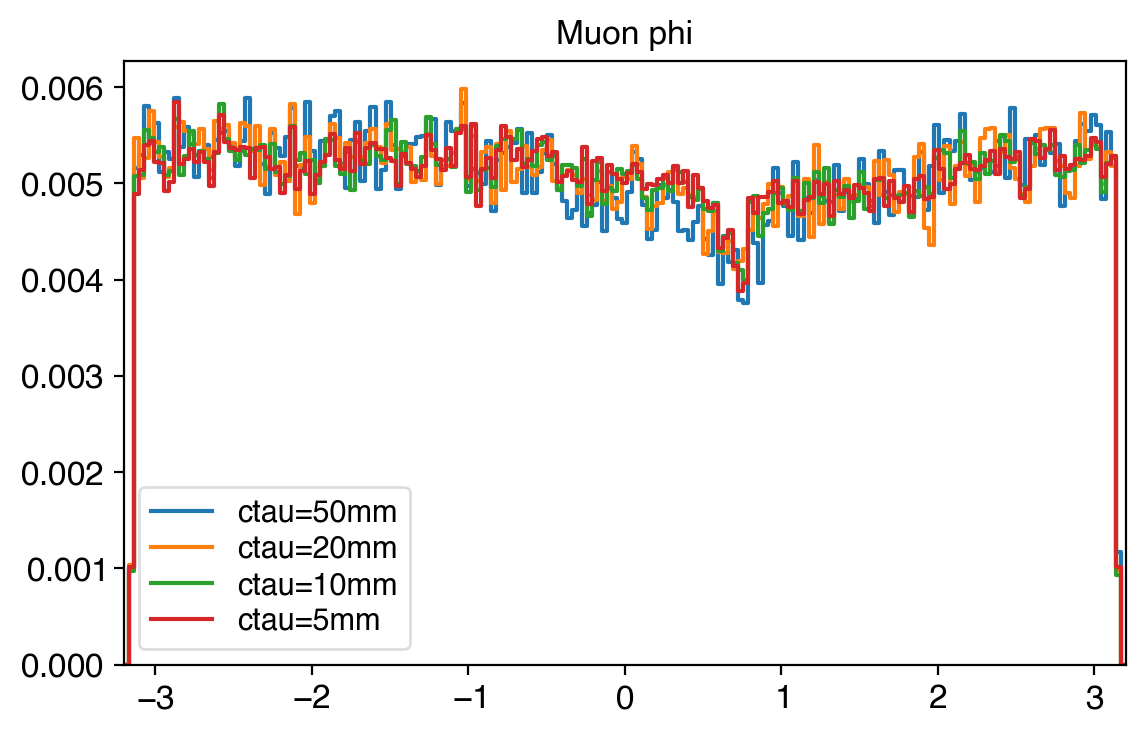

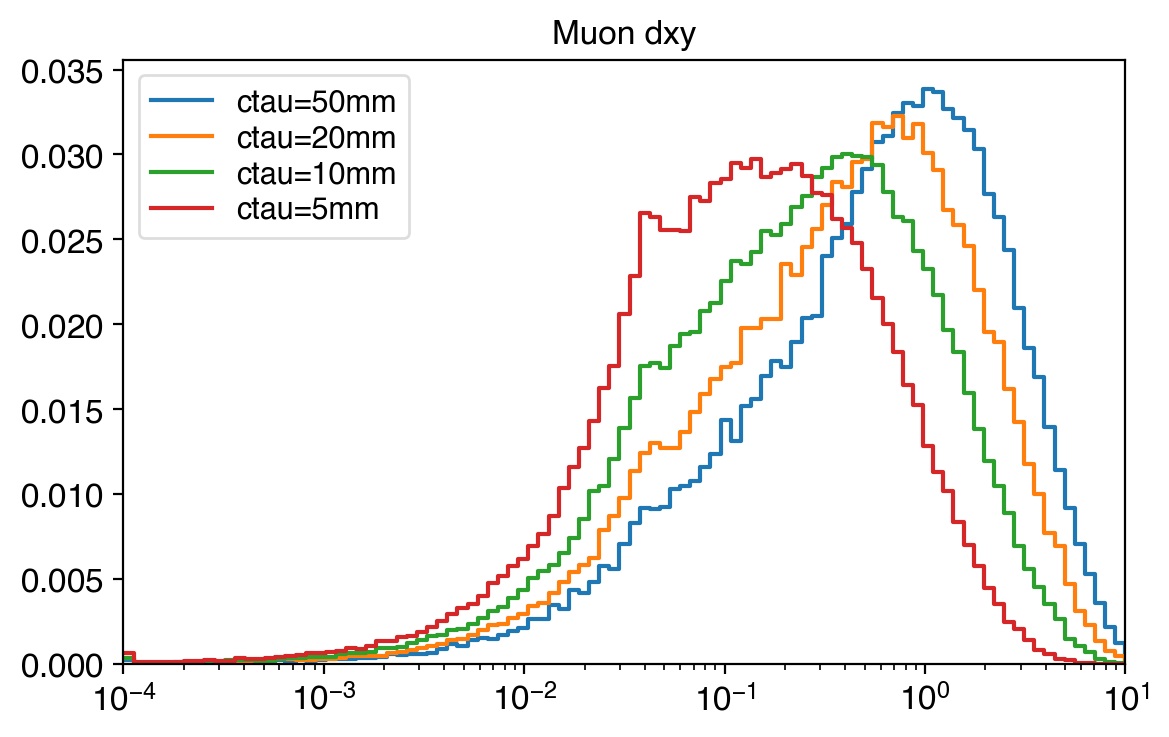

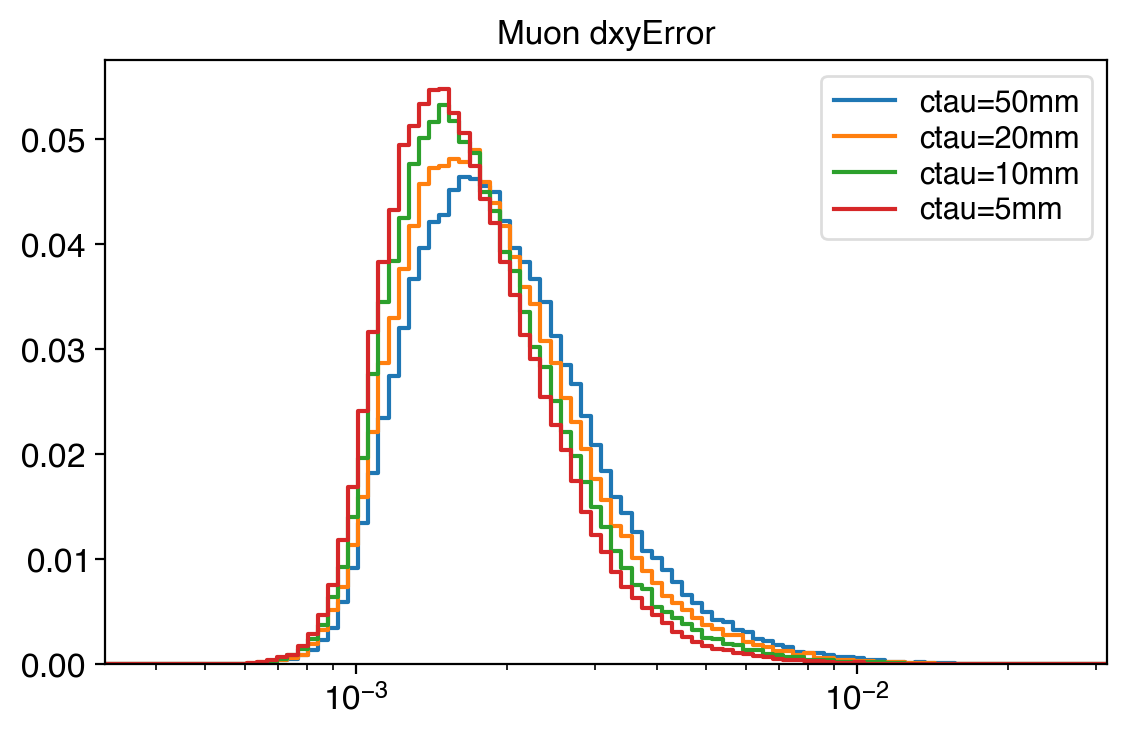

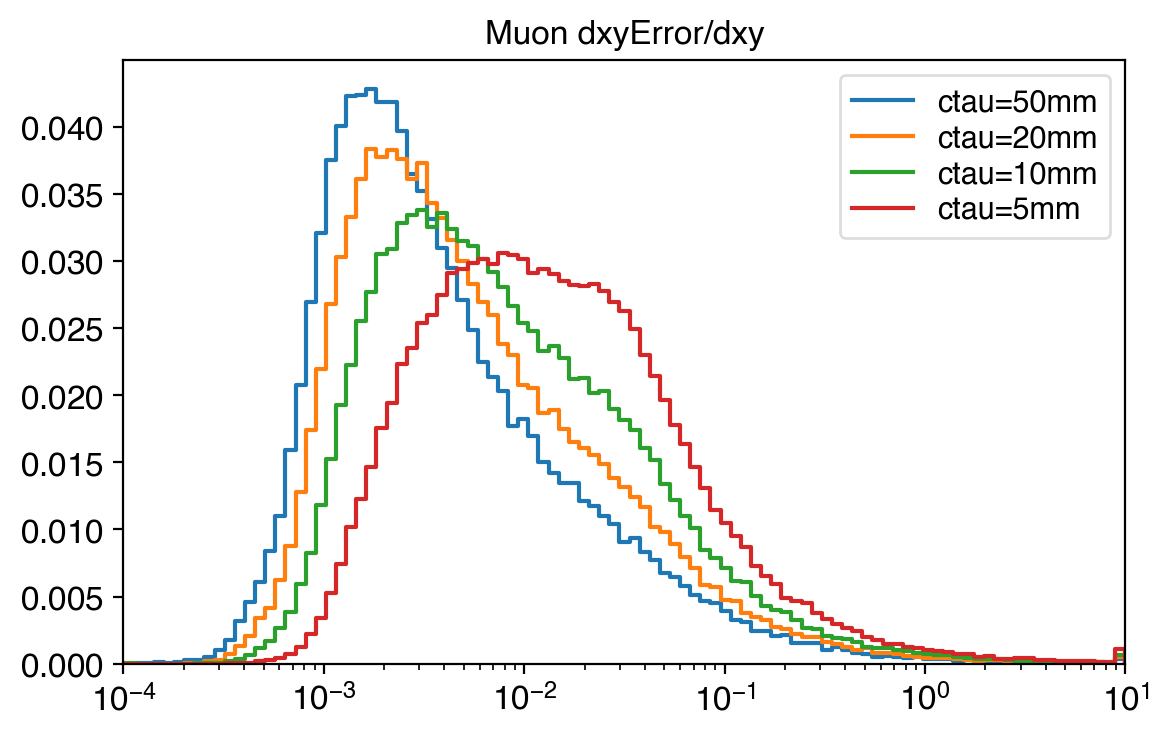

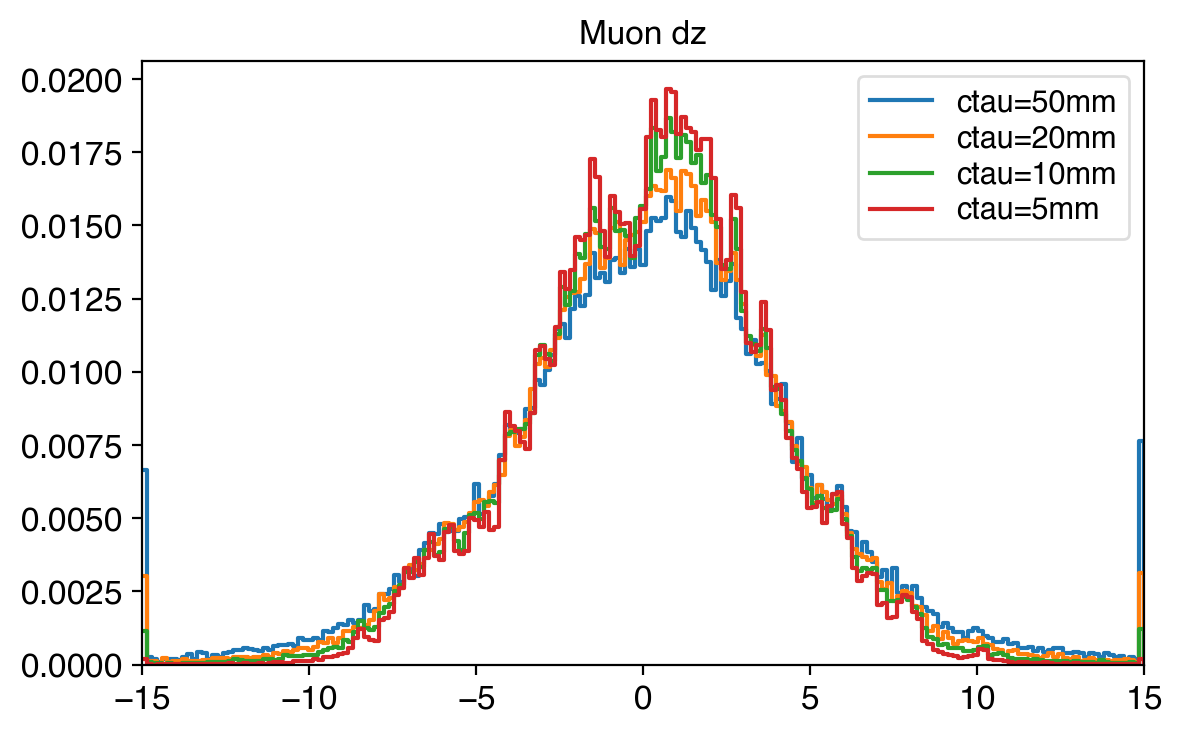

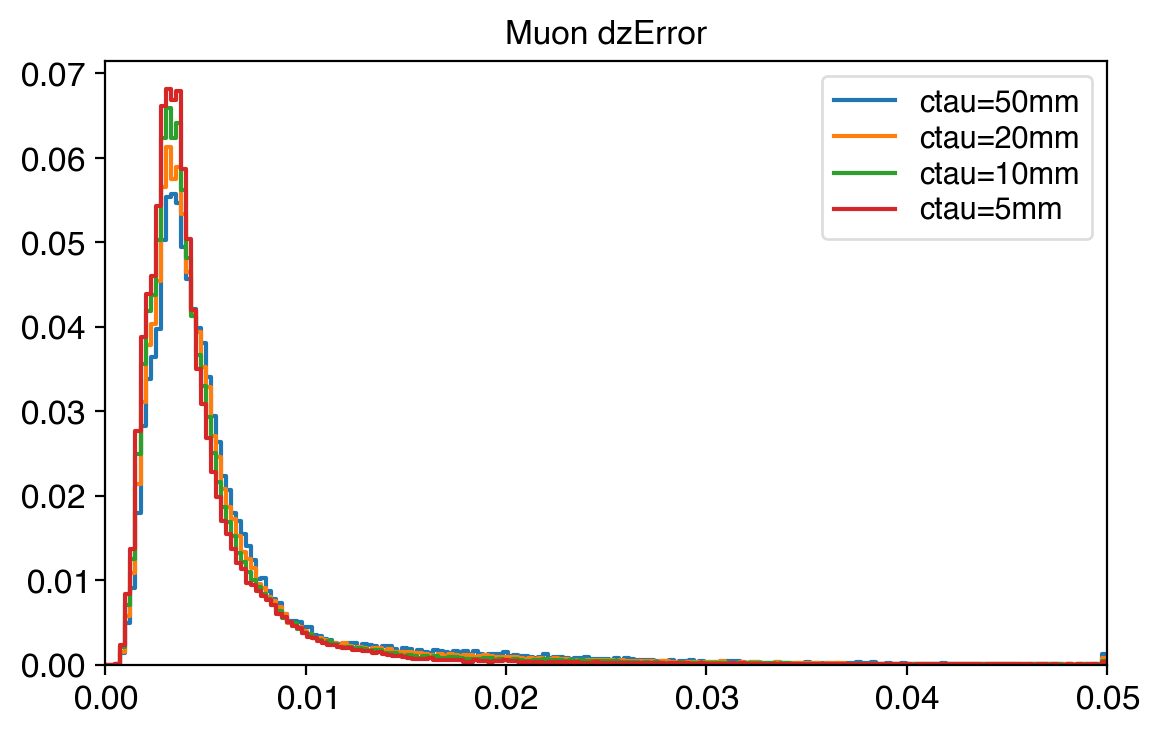

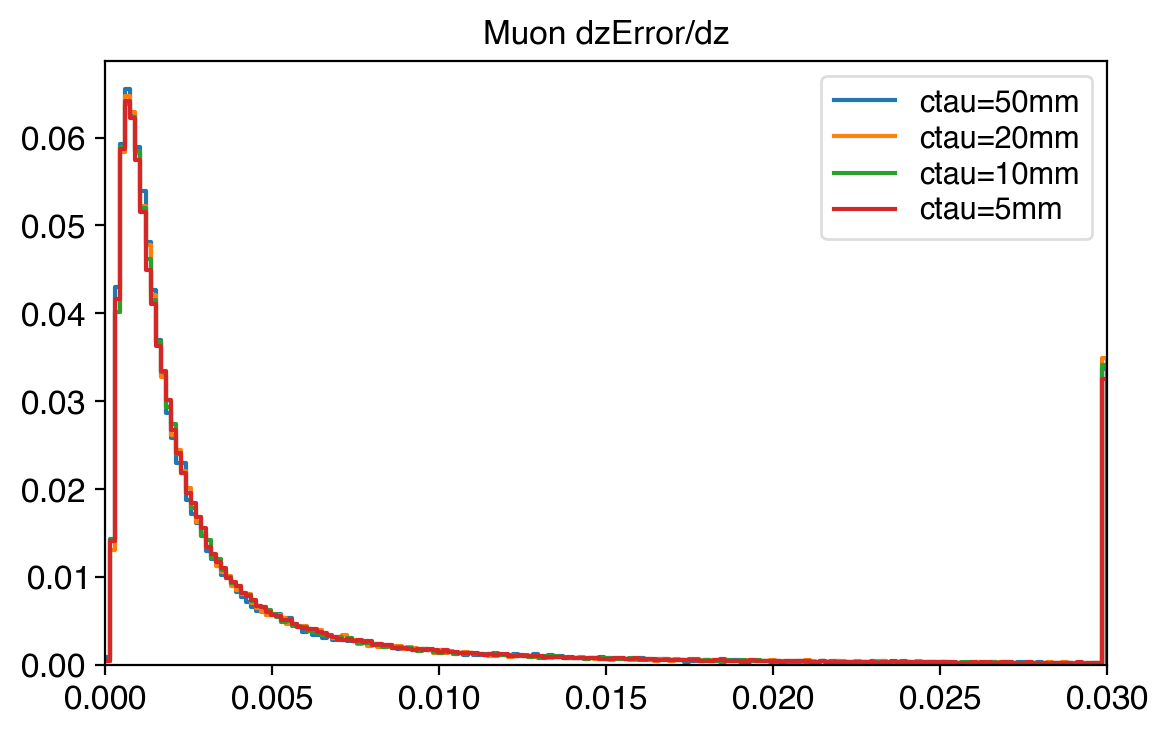

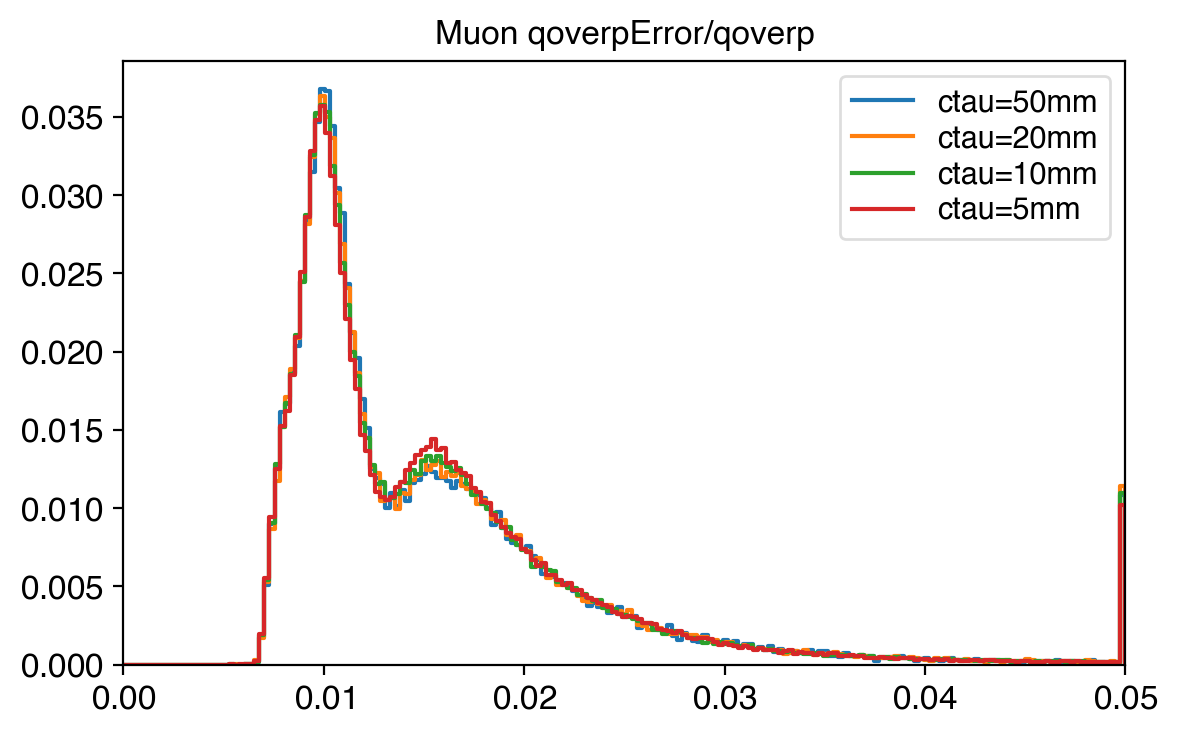

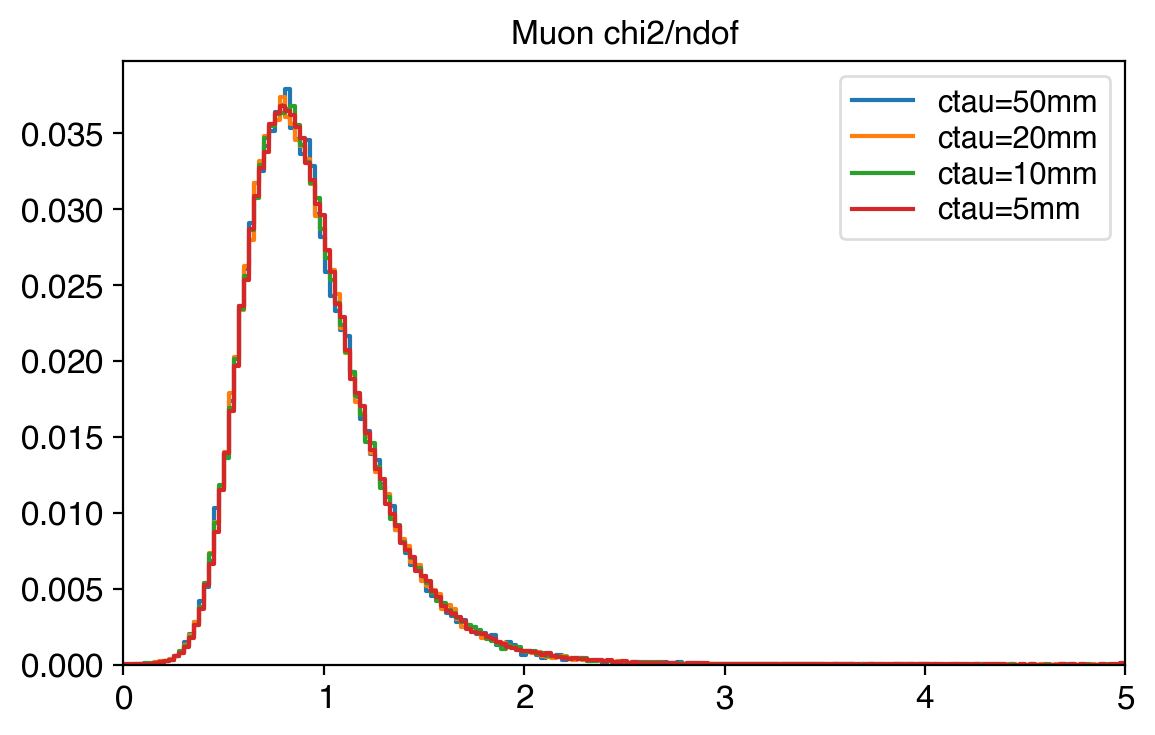

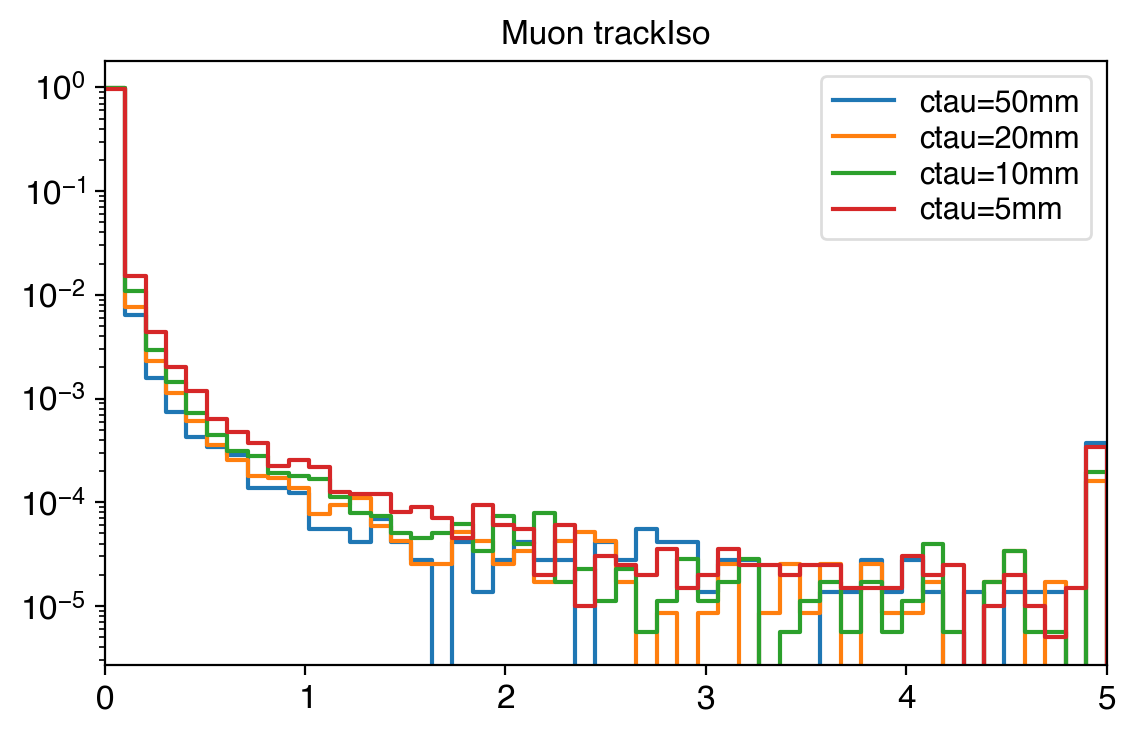

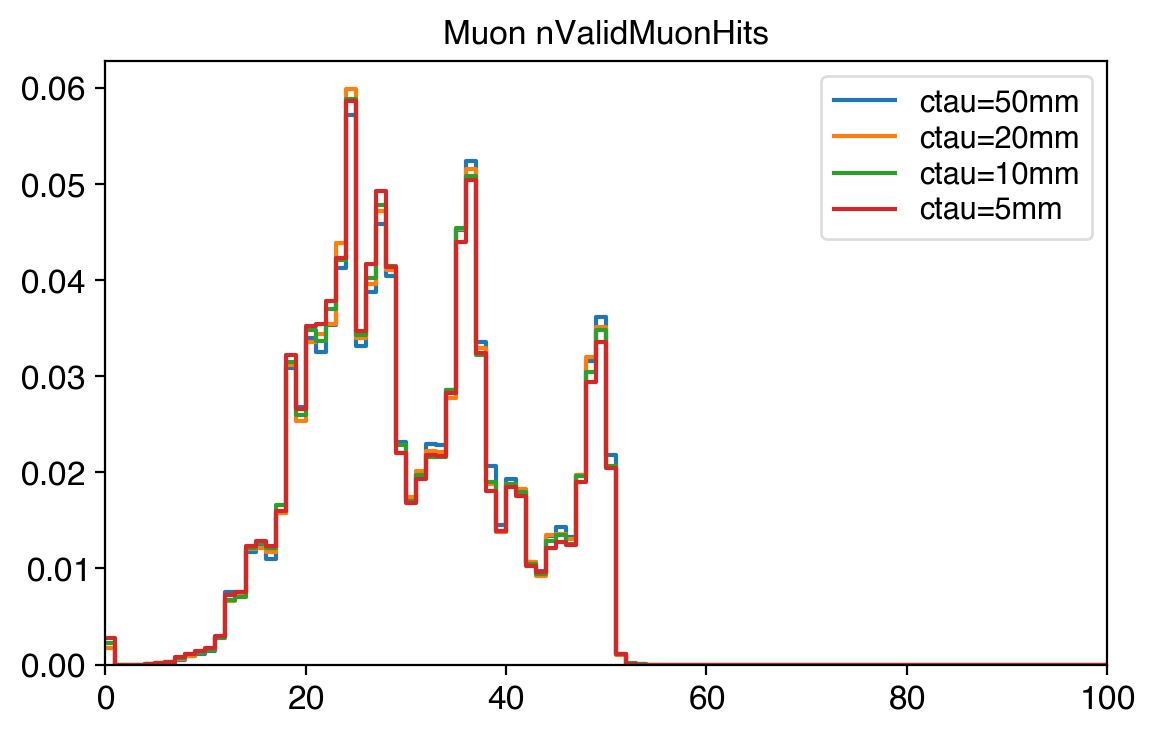

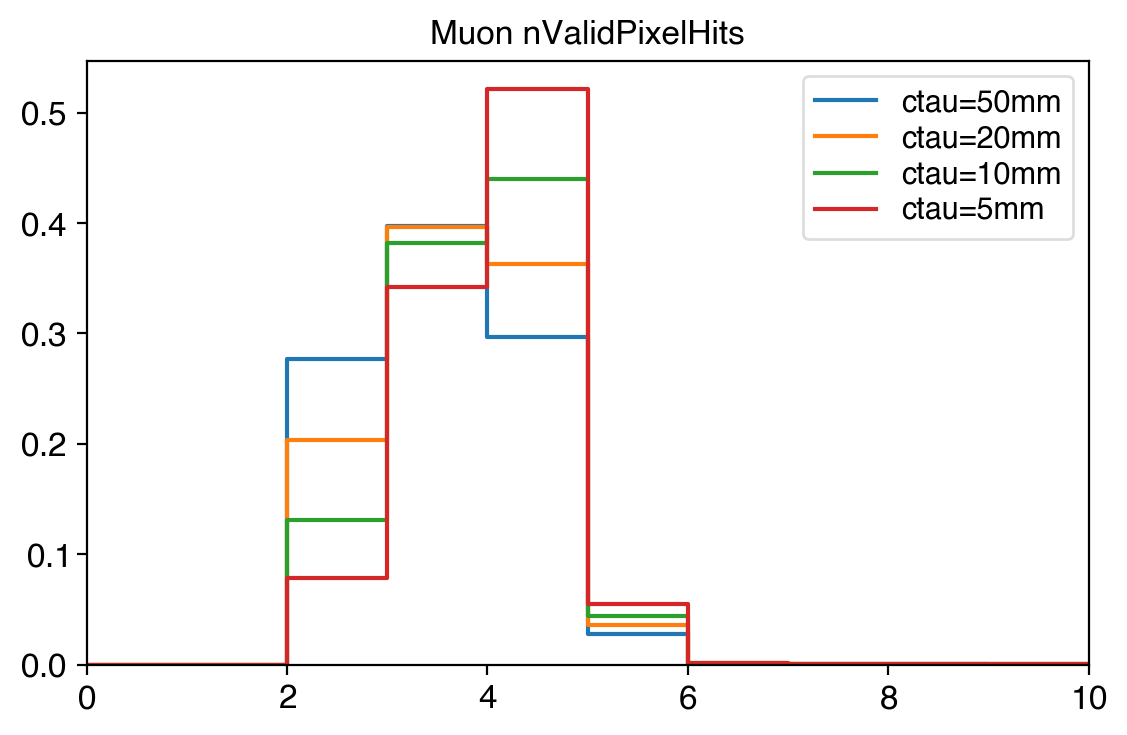

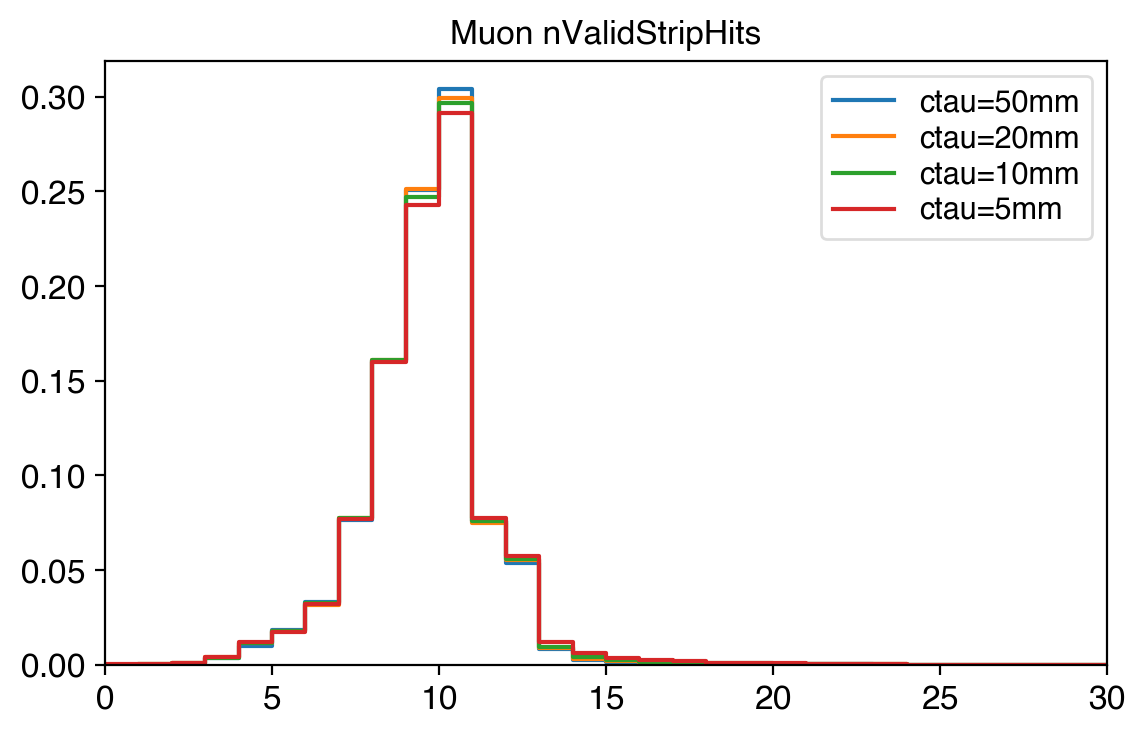

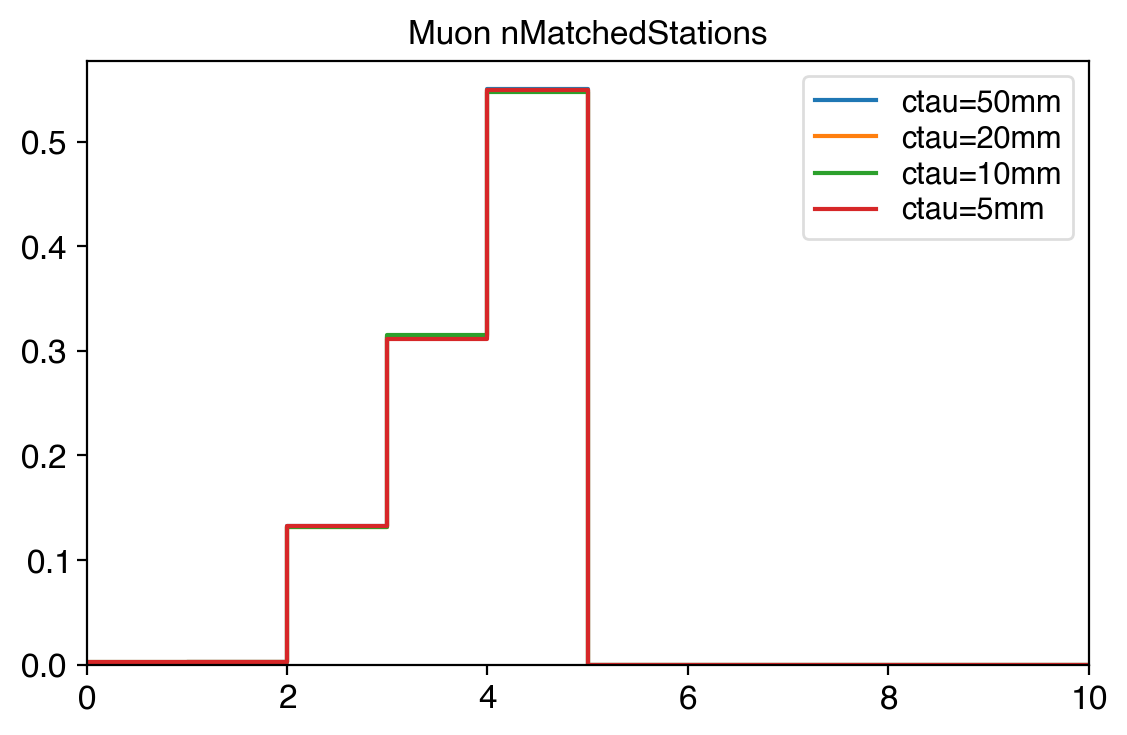

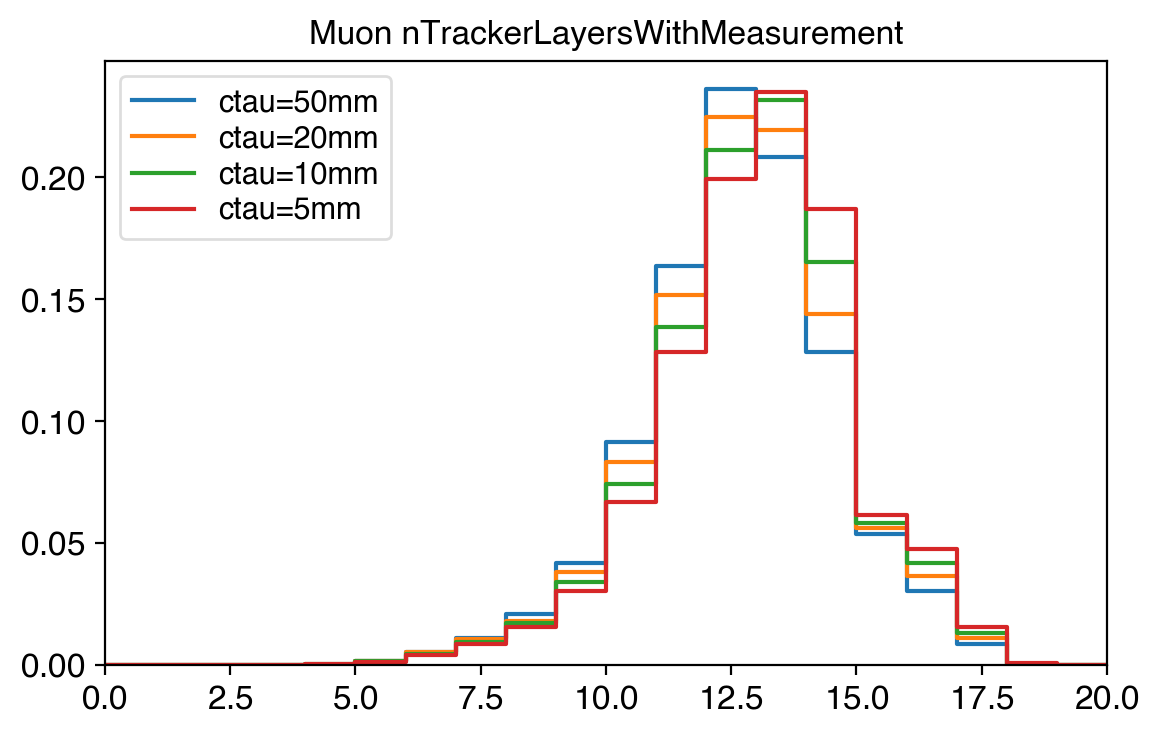

In [414]:

def singleplot(varname,do_abs=False):
    if do_abs:
        return lambda which:np.abs(fsctaus[which][varname].array(**readkw))[:,[0,1]].flatten()
    else:
        return lambda which:(fsctaus[which][varname].array(**readkw))[:,[0,1]].flatten()

def ratioplot(varname1,varname2,do_abs=False):
    if do_abs:
        return lambda which:np.abs(fsctaus[which][varname1].array(**readkw)/fsctaus[which][varname2].array(**readkw))[:,[0,1]].flatten()
    else:
        return lambda which:(fsctaus[which][varname1].array(**readkw)/fsctaus[which][varname2].array(**readkw))[:,[0,1]].flatten()

def rhoplot():
    return lambda which: np.hypot(fsctaus[which].array("DV_x",**readkw)[:,0]-bsxctau[which],fsctaus[which].array("DV_y",**readkw)[:,0]-bsyctau[which])

def costhetaplot():
    return lambda which: uproot_methods.TVector2Array.from_polar(
                fsctaus[which].array("Muon_pt",**readkw)[:,[0,1]],fsctaus[which].array("Muon_phi",**readkw)[:,[0,1]]
            ).cosdelta(
                uproot_methods.TVector2Array.from_cartesian(
                    fsctaus[which].array("DV_x",**readkw)[:,[0]],fsctaus[which].array("DV_y",**readkw)[:,[0]]
                )
    ).flatten()
        
def dvrplot():
    return lambda which: ((fsctaus[which]["DV_xError"].array(**readkw)**2.
         +fsctaus[which]["DV_yError"].array(**readkw)**2.
         +fsctaus[which]["DV_zError"].array(**readkw)**2.
         )**0.5/
        (fsctaus[which]["DV_x"].array(**readkw)**2.
         +fsctaus[which]["DV_y"].array(**readkw)**2.
         +fsctaus[which]["DV_z"].array(**readkw)**2.
         )**0.5)[:,0]

plots = [
    [np.logspace(-4,1.5,100),rhoplot(),dict(label="DV rho",logx=True,logy=False)],
    [np.linspace(0,0.05,100),dvrplot(),dict(label="DV rError/r",logx=False,logy=False)],
    [np.linspace(-1,1,30),costhetaplot(),dict(label="cosTheta",logx=False,logy=False)],
    
    [np.linspace(0,100,200),singleplot("Muon_pt"),dict(label="Muon pT",logx=False,logy=False)],
    [np.linspace(-2.5,2.5,200),singleplot("Muon_eta"),dict(label="Muon eta",logx=False,logy=False)],
    [np.linspace(-3.2,3.2,200),singleplot("Muon_phi"),dict(label="Muon phi",logx=False,logy=False)],
    
    [np.logspace(-4.,1,100),singleplot("Muon_dxy",do_abs=True),dict(label="Muon dxy",logx=True,logy=False)],
    [np.logspace(-3.5,-1.5,100),singleplot("Muon_dxyError"),dict(label="Muon dxyError",logx=True,logy=False)],
    [np.logspace(-4,1,100),ratioplot("Muon_dxyError","Muon_dxy",do_abs=True),dict(label="Muon dxyError/dxy",logx=True,logy=False)],
    [np.linspace(-15,15,200),singleplot("Muon_dz"),dict(label="Muon dz",logx=False,logy=False)],
    [np.linspace(0,0.05,200),singleplot("Muon_dzError"),dict(label="Muon dzError",logx=False,logy=False)],
    [np.linspace(0,0.03,200),ratioplot("Muon_dzError","Muon_dz",do_abs=True),dict(label="Muon dzError/dz",logx=False,logy=False)],
    [np.linspace(0,0.05,200),ratioplot("Muon_trk_qoverpError","Muon_trk_qoverp",do_abs=True),dict(label="Muon qoverpError/qoverp",logx=False,logy=False)],
    
    [np.linspace(0,5,200),ratioplot("Muon_chi2","Muon_ndof"),dict(label="Muon chi2/ndof",logx=False,logy=False)],
    [np.linspace(0,5,50),singleplot("Muon_trackIso"),dict(label="Muon trackIso",logx=False,logy=True)],
    
    [np.linspace(0,100,101),singleplot("Muon_nValidMuonHits"),dict(label="Muon nValidMuonHits",logx=False,logy=False)],
    [np.linspace(0,10,11),singleplot("Muon_nValidPixelHits"),dict(label="Muon nValidPixelHits",logx=False,logy=False)],
    [np.linspace(0,30,31),singleplot("Muon_nValidStripHits"),dict(label="Muon nValidStripHits",logx=False,logy=False)],
    [np.linspace(0,10,11),singleplot("Muon_nMatchedStations"),dict(label="Muon nMatchedStations",logx=False,logy=False)],
    [np.linspace(0,20,21),singleplot("Muon_nTrackerLayersWithMeasurement"),dict(label="Muon nTrackerLayersWithMeasurement",logx=False,logy=False)],
    
]

# plots = [
#     [np.logspace(-4,1.5,100),rhoplot(),dict(label="DV rho",logx=True,logy=False)],
# ]

for bins,varf,extra in plots:
    fig,ax = plt.subplots()
    print(extra)
    for which in [50,20,10,5]:
        var = varf(which)
        counts,edges = numba_histogram(var,bins=bins,overflow=True)
        ax.step(edges,np.append(counts/counts.sum(),0),
                where="post",
                label="ctau={}mm".format(which),
               )
    if extra.get("logx"):
        ax.set_xscale("log")
    if extra.get("logy"):
        ax.set_yscale("log")
    ax.set_ylim(max(0,ax.get_ylim()[0]),ax.get_ylim()[1])
    ax.set_title(extra.get("label"))
    ax.legend()

In [415]:
print(bsxctau)
print(bsyctau)

{50: 0.010777917, 20: 0.010777995, 10: 0.010777827, 5: 0.01077764}
{50: 0.041893788, 20: 0.04189375, 10: 0.04189382, 5: 0.04189391}


In [417]:
fsctaus[50]

<TTree b'Events' at 0x7fb5f5dfe748>

In [510]:
t = fsctaus[50]

tlead = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("LeadingPair_*",outputtype=dict,namedecode="ascii").items()})
tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii").items()})

tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
tdv["rho"] = np.hypot(tdv.x,tdv.y)
tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)
tmu["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tmu.pt,tmu.eta,tmu.phi,tmu.m)

In [511]:
mu1 = uproot_methods.TLorentzVectorArray.from_ptetaphim(tmu.pt[:,0],tmu.eta[:,0],tmu.phi[:,0],tmu.m[:,0])
mu2 = uproot_methods.TLorentzVectorArray.from_ptetaphim(tmu.pt[:,1],tmu.eta[:,1],tmu.phi[:,1],tmu.m[:,1])

mreco = (tmu["p4"][:,0]+tmu["p4"][:,1]).mass
mgen = (tgen["p4"][:,0]+tgen["p4"][:,1]).mass

gen2mu = tgen.pt.counts == 2

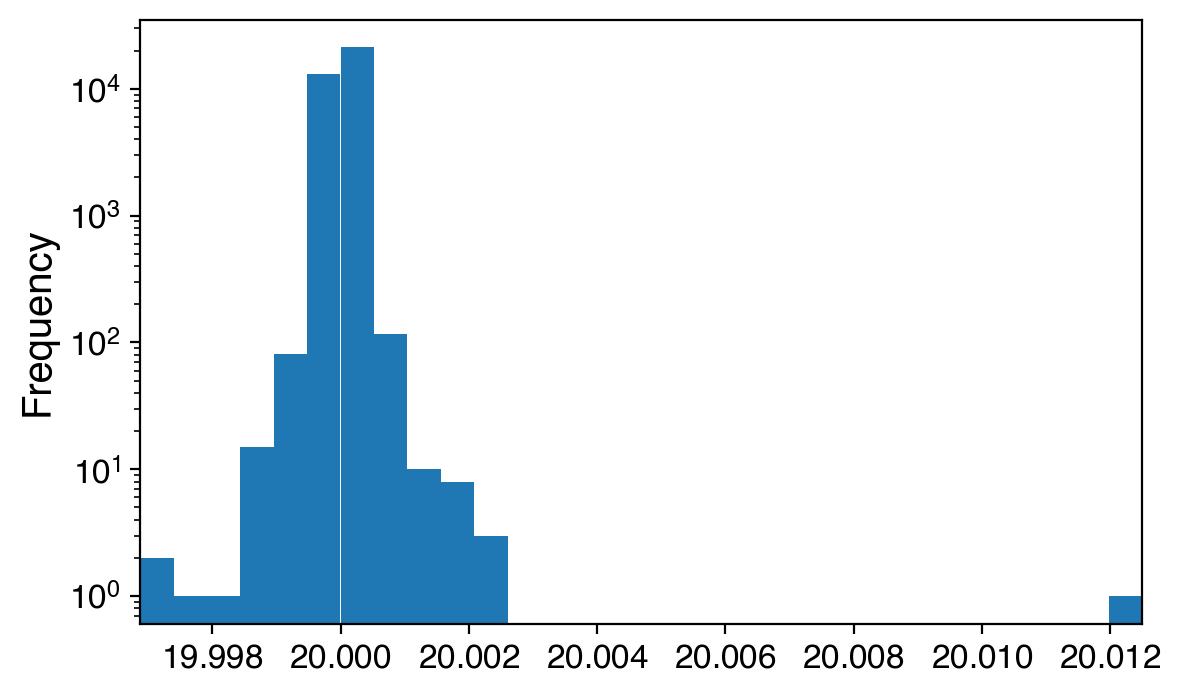

In [512]:
# mreco
pd.Series(mgen[gen2mu]).plot.hist(bins=30,logy=True)

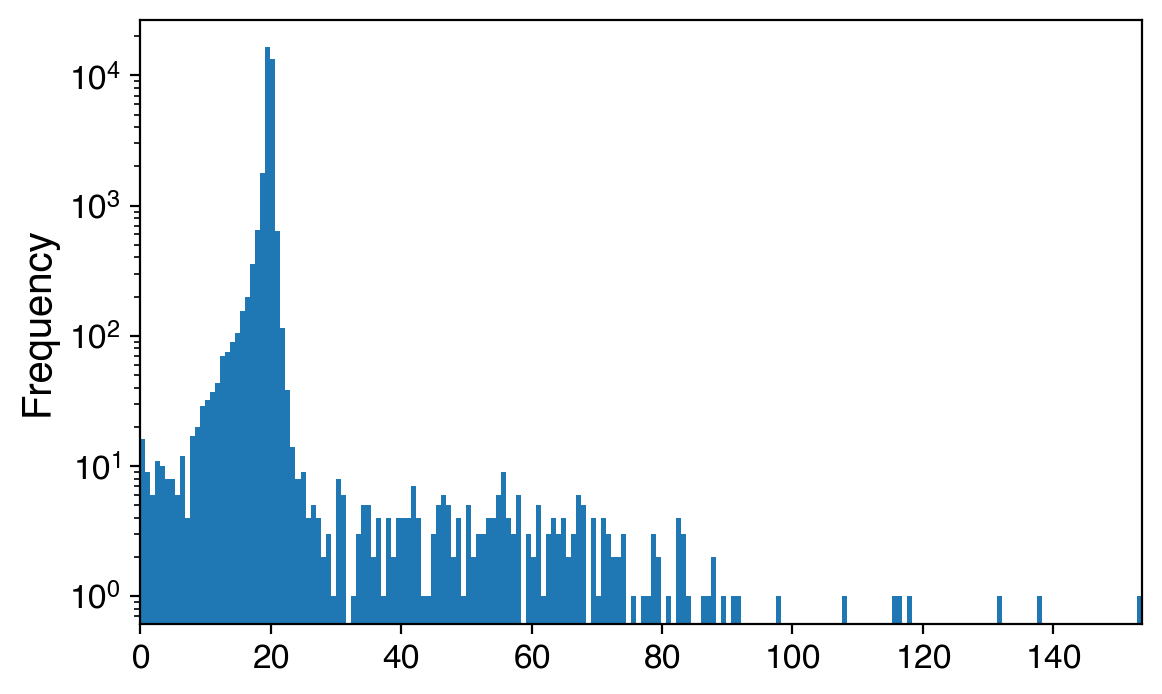

In [513]:
pd.Series(mreco[gen2mu]).plot.hist(bins=200,logy=True)

In [514]:
mreco[np.abs(mreco-20)<20].std()

1.6539553

In [515]:
pd.Series(tmu.pt[gen2mu].counts).value_counts()

2    33351
3     1220
4       52
dtype: int64

In [516]:
mm = tmu["p4"][gen2mu].distincts()
mass = (mm.i0+mm.i1).mass
print(pd.Series(np.abs(mass-20.).argmin().flatten()).value_counts())
closestmass = mass[np.abs(mass-20.).argmin()].flatten()

0    34347
1      190
2       81
5        2
4        2
3        1
dtype: int64


In [536]:
# pd.Series(tdv.x[~gen2mu].counts).value_counts()
tdv.rho[gen2mu][:,0].shape

(34623,)

In [537]:
closestmass.shape

(34623,)

In [ ]:
%%time
from scipy.stats import binned_statistic
# edges = np.logspace(0.,1.5,200)
edges = np.linspace(0.0,20.,200)
yvals = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'mean', bins=edges).statistic
yerr = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'std', bins=edges).statistic/(binned_statistic(rho, costheta, 'count', bins=edges).statistic**0.5)
fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o')
ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# ax.set_xscale("log")
ax.set_ylabel(r"Mean cos$\theta$")
ax.set_xlabel("DV rho")